In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.tsa.arima_process import ArmaProcess
import scipy.linalg
import numpy.random as nrand
from arch import arch_model 
from scipy import stats
import scipy.stats as ss
import random
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
np.random.seed(24)

Сгенерировать процессы:
1. W Винеровский,
2. AR (с несколькими разными параметрами)
3. MA (с несколькими разными параметрами)
4. Марковский процесс
5. GARCH
6. геометрическое броуновское движение
7. Merton Jump diffusion
8. Heston Stochastic volatility
9. Cox–Ingersoll–Ross
10. Орнштейна-Уленбека

In [2]:
N_PATHES = 10

In [3]:
class ModelParameters:
    """
    Encapsulates model parameters
    """
    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0,
                 cir_a=0.0, cir_mu=0.0, all_r0=0.0, cir_rho=0.0,
                 ou_a=0.1, ou_mu=0.2,
                 heston_a=0.0, heston_mu=0.0, heston_vol0=0.0):
        
        self.all_s0 = all_s0 # starting asset value
        self.all_time = all_time # amount of time to simulate for
        self.all_delta = all_delta # delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_sigma = all_sigma # volatility of the stochastic processes
        self.gbm_mu = gbm_mu # annual drift factor for geometric brownian motion
        
        self.lamda = jumps_lamda # probability of a jump happening at each point in time
        self.jumps_sigma = jumps_sigma # volatility of the jump size
        self.jumps_mu = jumps_mu # average jump size
        
        self.cir_a = cir_a # rate of mean reversion for Cox Ingersoll Ross
        self.cir_mu = cir_mu # long run average interest rate for Cox Ingersoll Ross
        self.cir_rho = cir_rho # correlation between the wiener processes of the Heston model
        
        self.all_r0 = all_r0 # starting interest rate value
        
        self.ou_a = ou_a # rate of mean reversion for Ornstein Uhlenbeck
        self.ou_mu = ou_mu # long run average interest rate for Ornstein Uhlenbeck
        
        self.heston_a = heston_a # rate of mean reversion for volatility in the Heston model
        self.heston_mu = heston_mu # long run average volatility for the Heston model
        self.heston_vol0 = heston_vol0# starting volatility value for the Heston model

def convert_to_returns(log_returns):
    return np.exp(log_returns)

def convert_to_prices(param, log_returns):
    returns = convert_to_returns(log_returns)
    # A sequence of prices starting with param.all_s0
    price_sequence = [param.all_s0]
    for i in range(1, len(returns)):
        # Add the price at t-1 * return at t
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return np.array(price_sequence)


def brownian_motion_log_returns(param):
    sqrt_delta_sigma = np.sqrt(param.all_delta) * param.all_sigma
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)

def brownian_motion_levels(param):
    return convert_to_prices(param, brownian_motion_log_returns(param))


def plot_stochastic_processes(process_realisations, process_name: str, title=None):
    Npaths = process_realisations.shape[1]
    fig, axs = plt.subplots(nrows=2, figsize=(14, 8), dpi=200, sharex=True)
    fig.subplots_adjust(hspace=.05)
    fig.autofmt_xdate(rotation=45)
    [(ax.tick_params(axis='both', labelsize=8),
      ax.grid(alpha=.4),
      ax.axhline(y=params.all_s0, color='r', label='$\mu$')) for ax in axs]
    axs[0].plot(process_realisations[0], label=f'${process_name}_0$')
    axs[0].legend(fancybox=True, shadow=True, loc='lower right')
    label_names = [f'${process_name}_{i}$' for i in range(Npaths)]
    axs[1].plot(process_realisations, label=label_names, linewidth=.7)
    axs[1].plot(process_realisations[0])
    axs[1].legend(ncol=2, fancybox=True, shadow=True, loc='lower right')
    axs[0].set_title(f'Price simulations via {title} ({Npaths} realisation)')
    plt.show()
s0 = 50
N = 3 * 252
params = ModelParameters(all_s0 = s0,
                         all_time = N,
                         all_delta = .05,
                         all_sigma = .01,
                         gbm_mu =.05,
                         jumps_lamda = .2, # probability of a jump happening at each point in time
                         jumps_sigma = .05, # volatility of the jump size
                         jumps_mu = 0,
                         heston_a = .3, # rate of mean reversion for volatility in the Heston model
                         heston_mu = 0,# long run average volatility for the Heston model
                         heston_vol0 = .1, # starting volatility value for the Heston model) # average jump size
                         cir_a =.2, # rate of mean reversion for Cox Ingersoll Ross
                         cir_mu =.4, # long run average interest rate for Cox Ingersoll Ross
                         cir_rho=.1) # correlation between the wiener processes of the Heston model) 

N = params.all_time

# 1.1 Винеровский процесс (Brownian Motion)

$$X(t + dt) = X(t) + N(0 , \delta ^ 2 \cdot dt; t, t+dt)$$
 
where `N(a,b; t0, t1)` is a normally distributed random variable with mean `a` and
variance `b`.

The parameters `t0` and `t1` make explicit the statistical
independence of `N` on different time intervals.

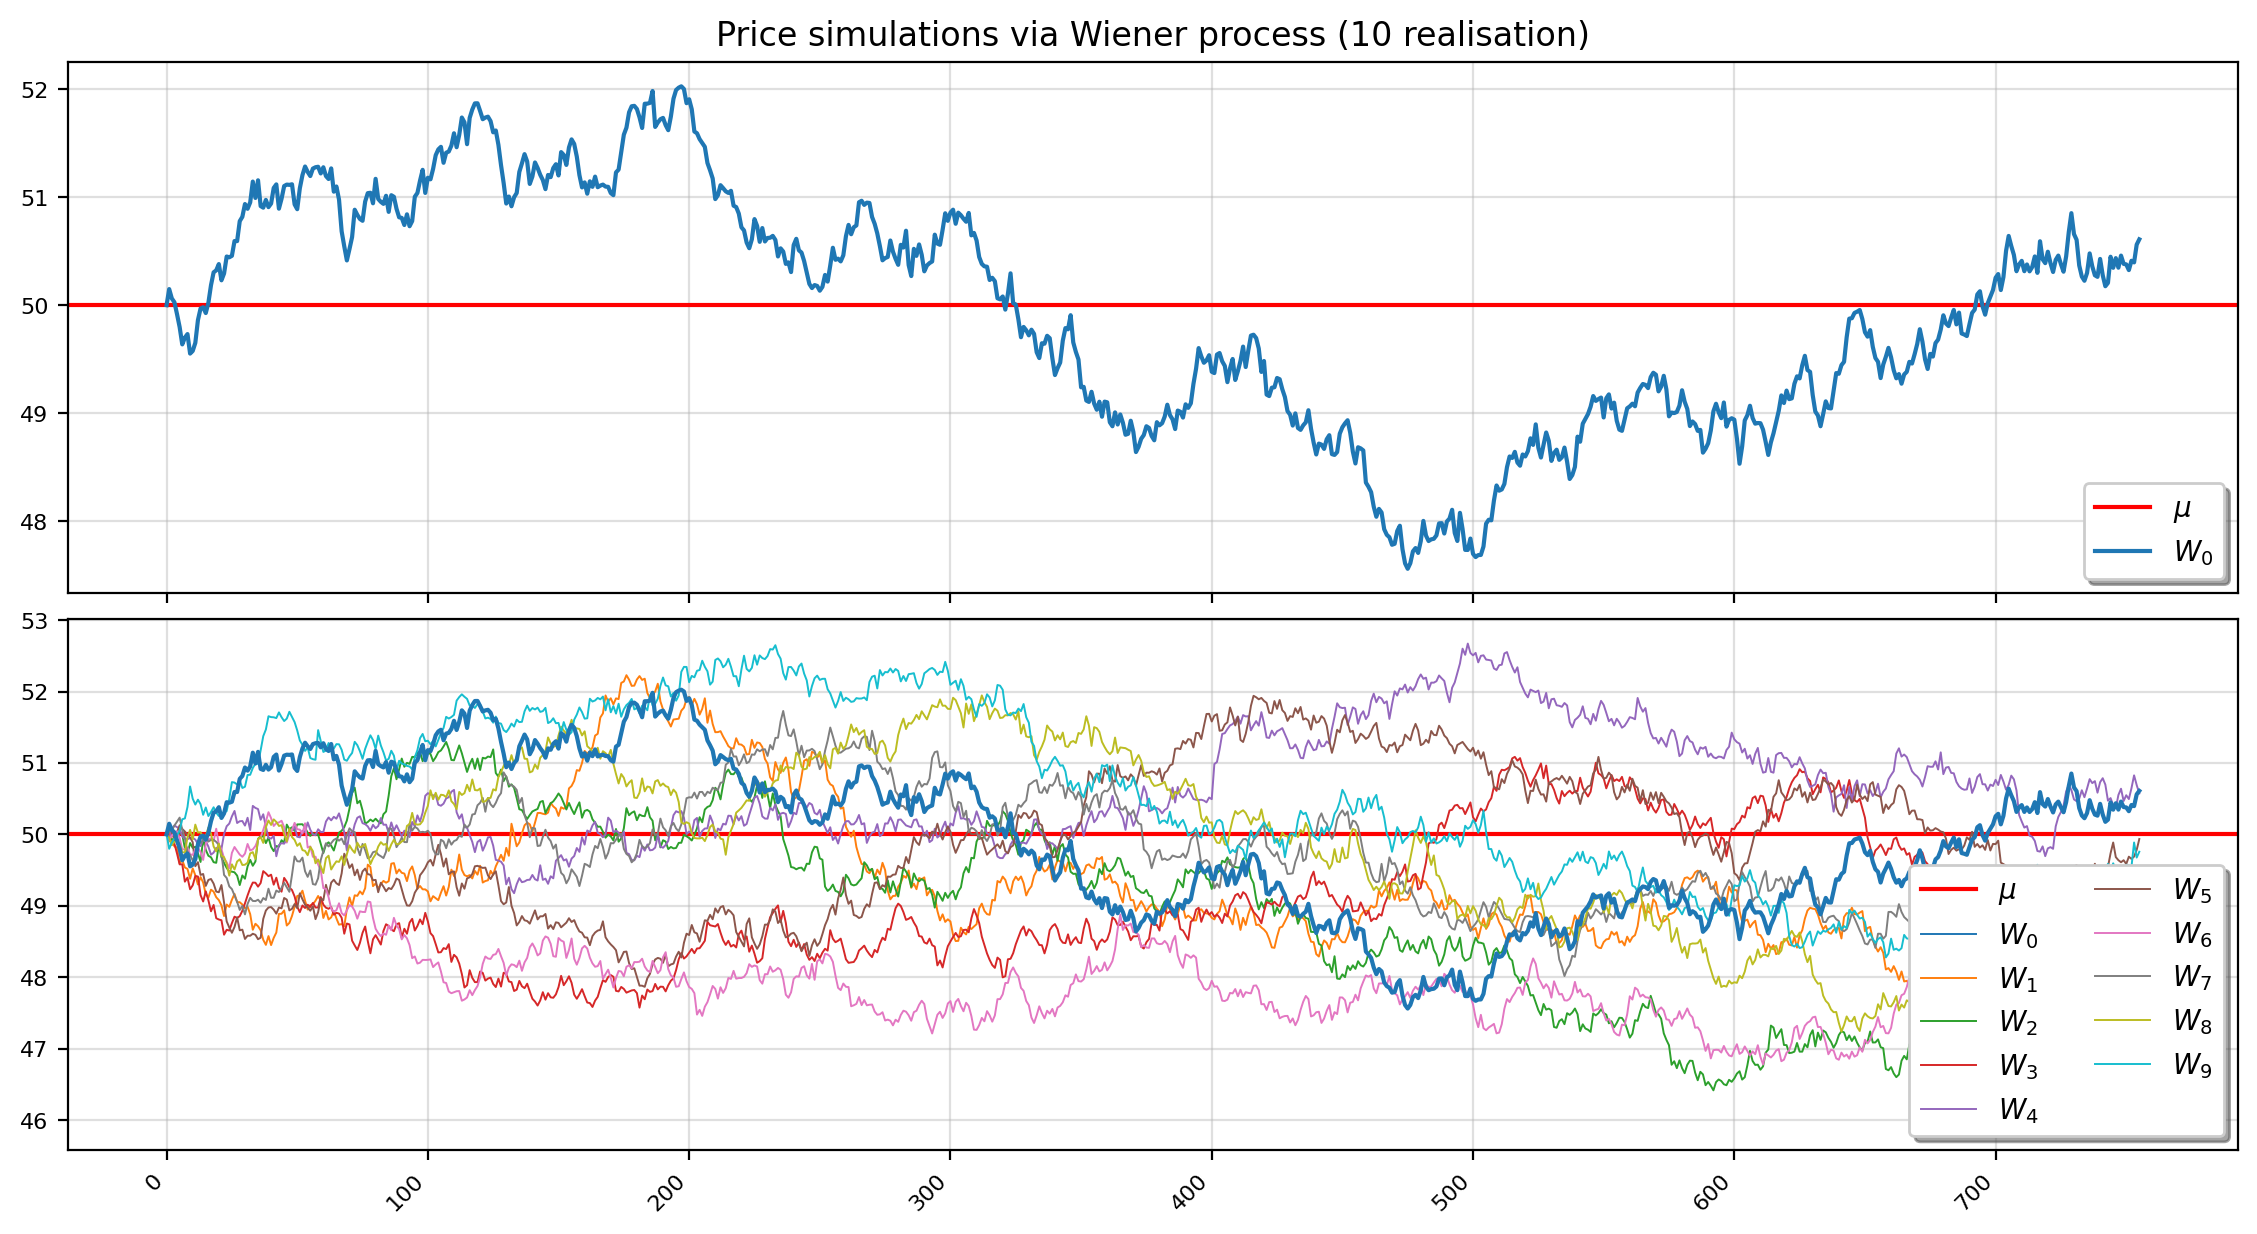

In [4]:
W_df = pd.DataFrame([brownian_motion_levels(params) for i in range(N_PATHES)]).T

plot_stochastic_processes(W_df, 'W', title='Wiener process')

# 1.2 Autoregressive AR(1) & AR(2)

#### Simulating $AR(1)$
$y_{t}=\mu + \alpha_{1}y_{t-1} + \varepsilon_{t}$

$\alpha_i \in [-0.9, -0.5, 0.5, 0.9]$



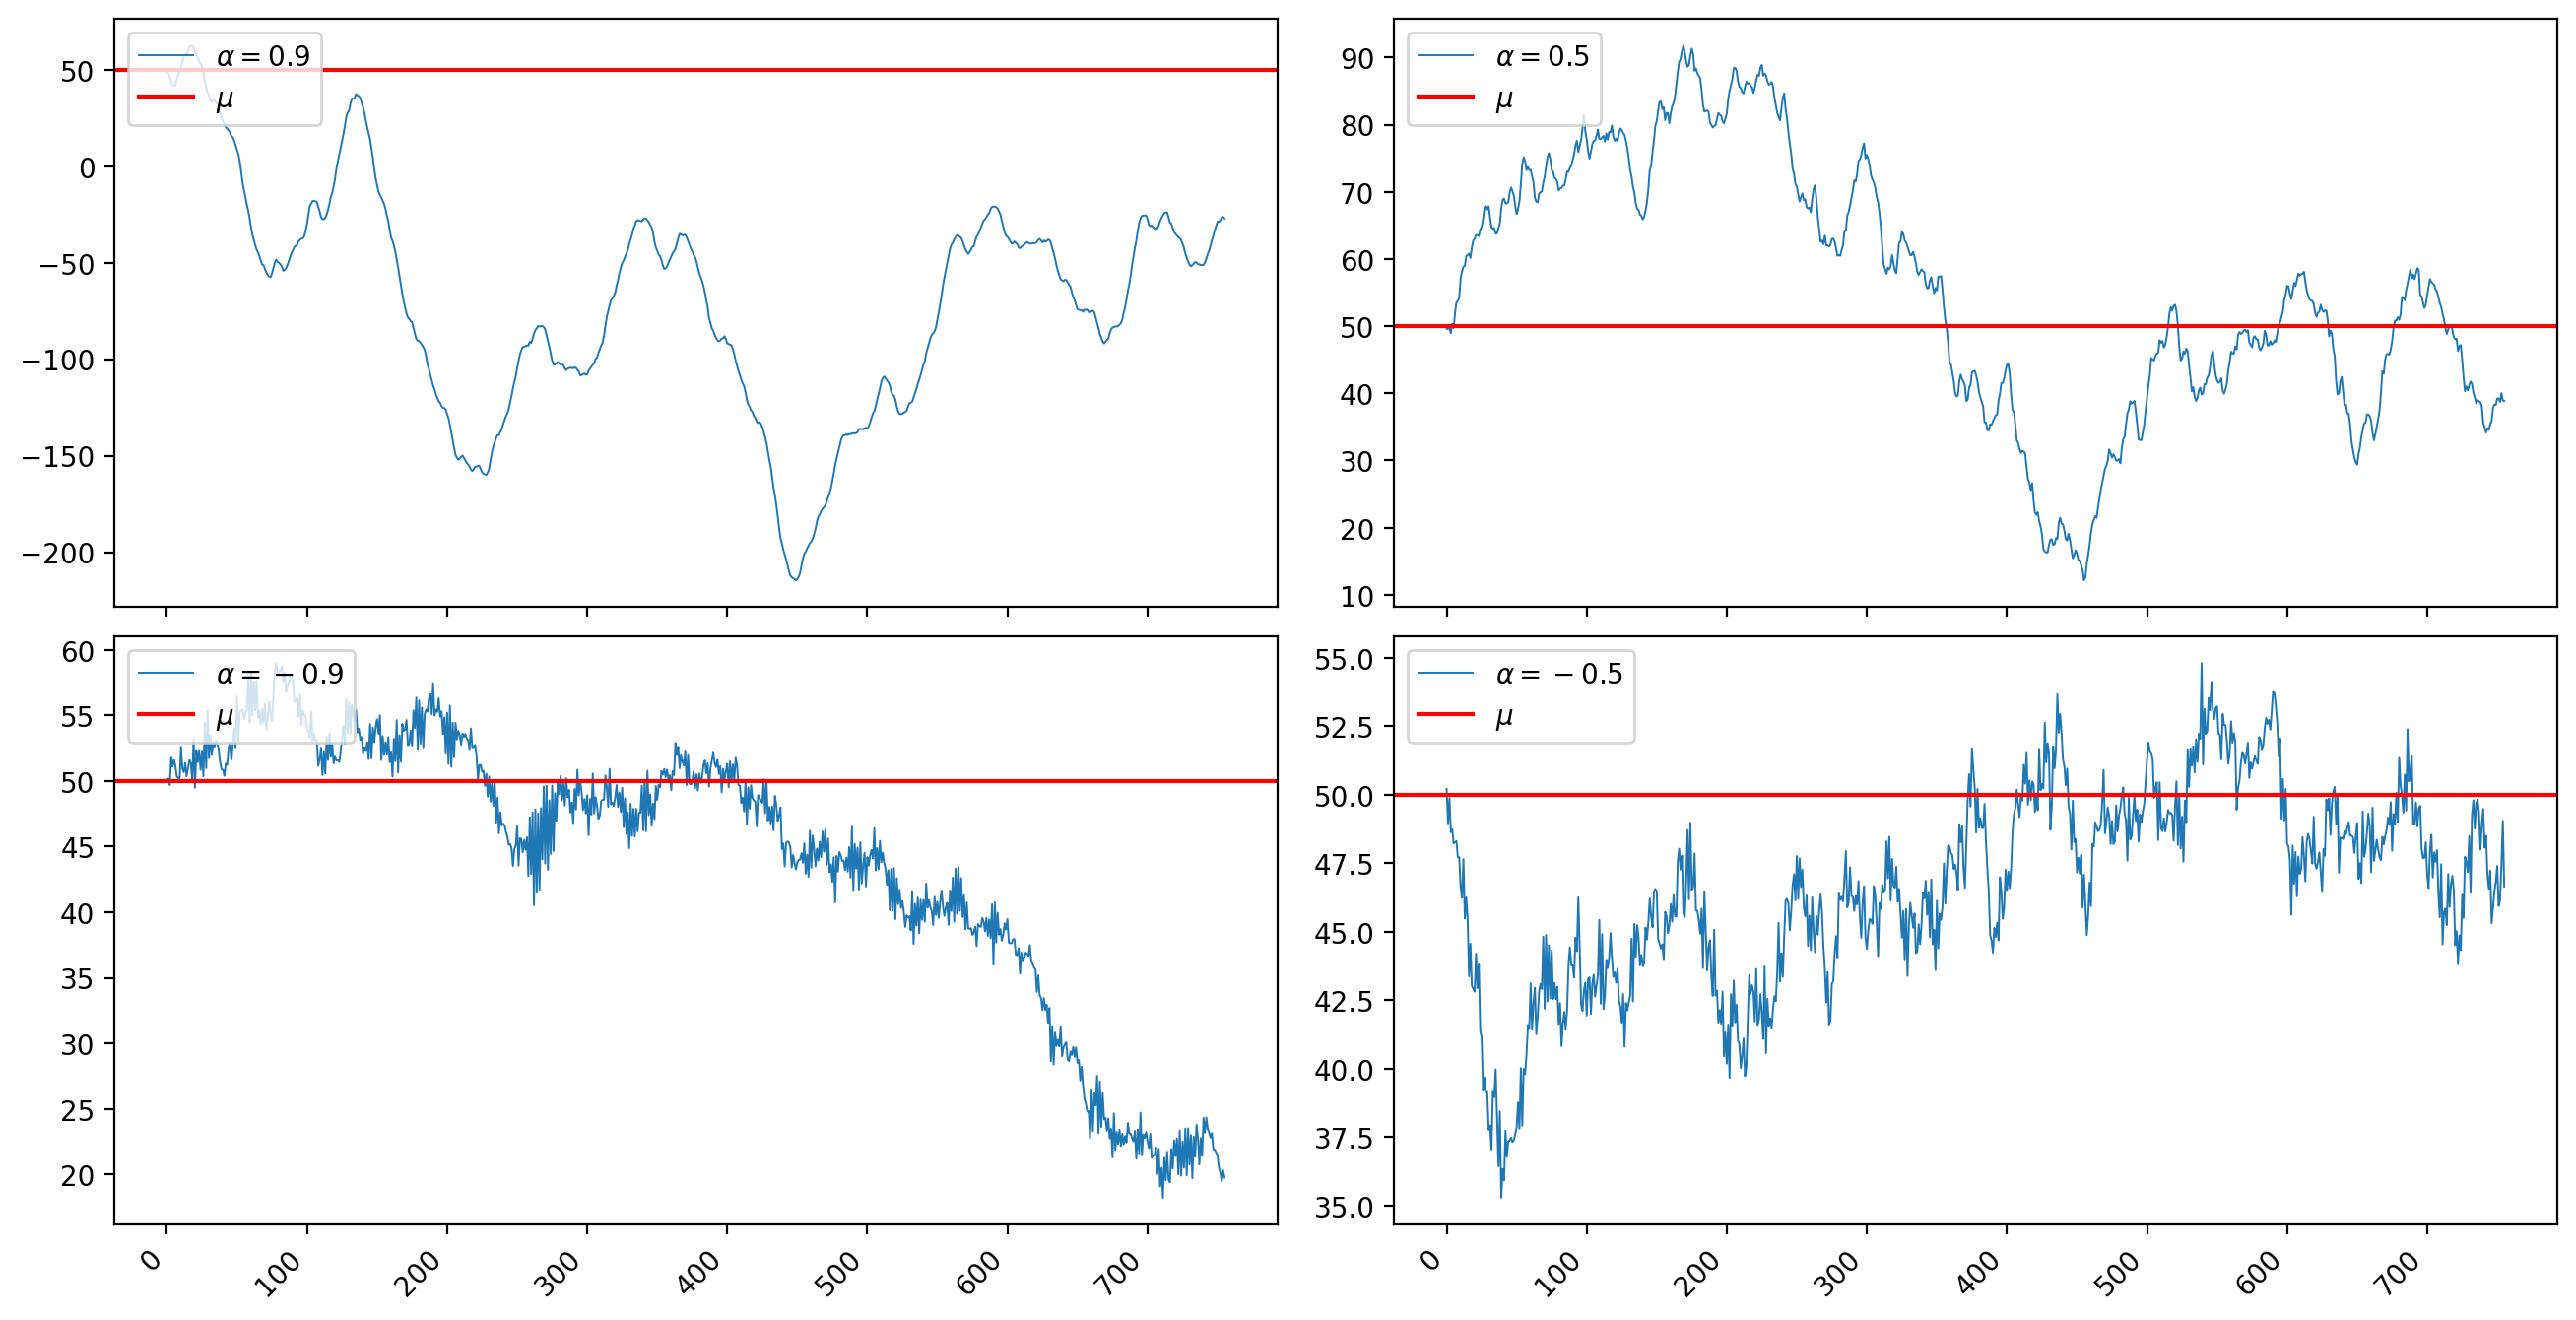

In [5]:
ar1_1 = [1, -0.9]
ar1_2 = [1, -0.5]
ar1_3 = [1, 0.5]
ar1_4 = [1, 0.9]
simulated_ar1_1 = params.all_s0 + np.cumsum(ArmaProcess(ar = ar1_1).generate_sample(nsample=N))
simulated_ar1_2 = params.all_s0 + np.cumsum(ArmaProcess(ar = ar1_2).generate_sample(nsample=N))
simulated_ar1_3 = params.all_s0 + np.cumsum(ArmaProcess(ar = ar1_3).generate_sample(nsample=N))
simulated_ar1_4 = params.all_s0 + np.cumsum(ArmaProcess(ar = ar1_4).generate_sample(nsample=N))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 9), sharex=True, dpi=200)
fig.subplots_adjust(hspace=.05, wspace=.1)
fig.autofmt_xdate(rotation=45)
axs[0][0].plot(simulated_ar1_1, linewidth=.7, label=r'$\alpha= 0.9$')
axs[0][0].axhline(y=params.all_s0, color='r', label='$\mu$')
axs[0][0].legend(loc = 'upper left')

axs[0][1].plot(simulated_ar1_2, linewidth=.7, label=r'$\alpha= 0.5$')
axs[0][1].axhline(y=params.all_s0, color='r', label='$\mu$')
axs[0][1].legend(loc = 'upper left')

axs[1][0].plot(simulated_ar1_4, linewidth=.7, label=r'$\alpha= -0.9$')
axs[1][0].axhline(y=params.all_s0, color='r', label='$\mu$')
axs[1][0].legend(loc = 'upper left')

axs[1][1].plot(simulated_ar1_3, linewidth=.7, label=r'$\alpha= -0.5$')
axs[1][1].axhline(y=params.all_s0, color='r', label='$\mu$')
axs[1][1].legend(loc = 'upper left')
plt.show()

# 1.3 Moving-average MA (1) process $$y_t = \mu + \varepsilon_t + \theta \varepsilon_{t-1}$$

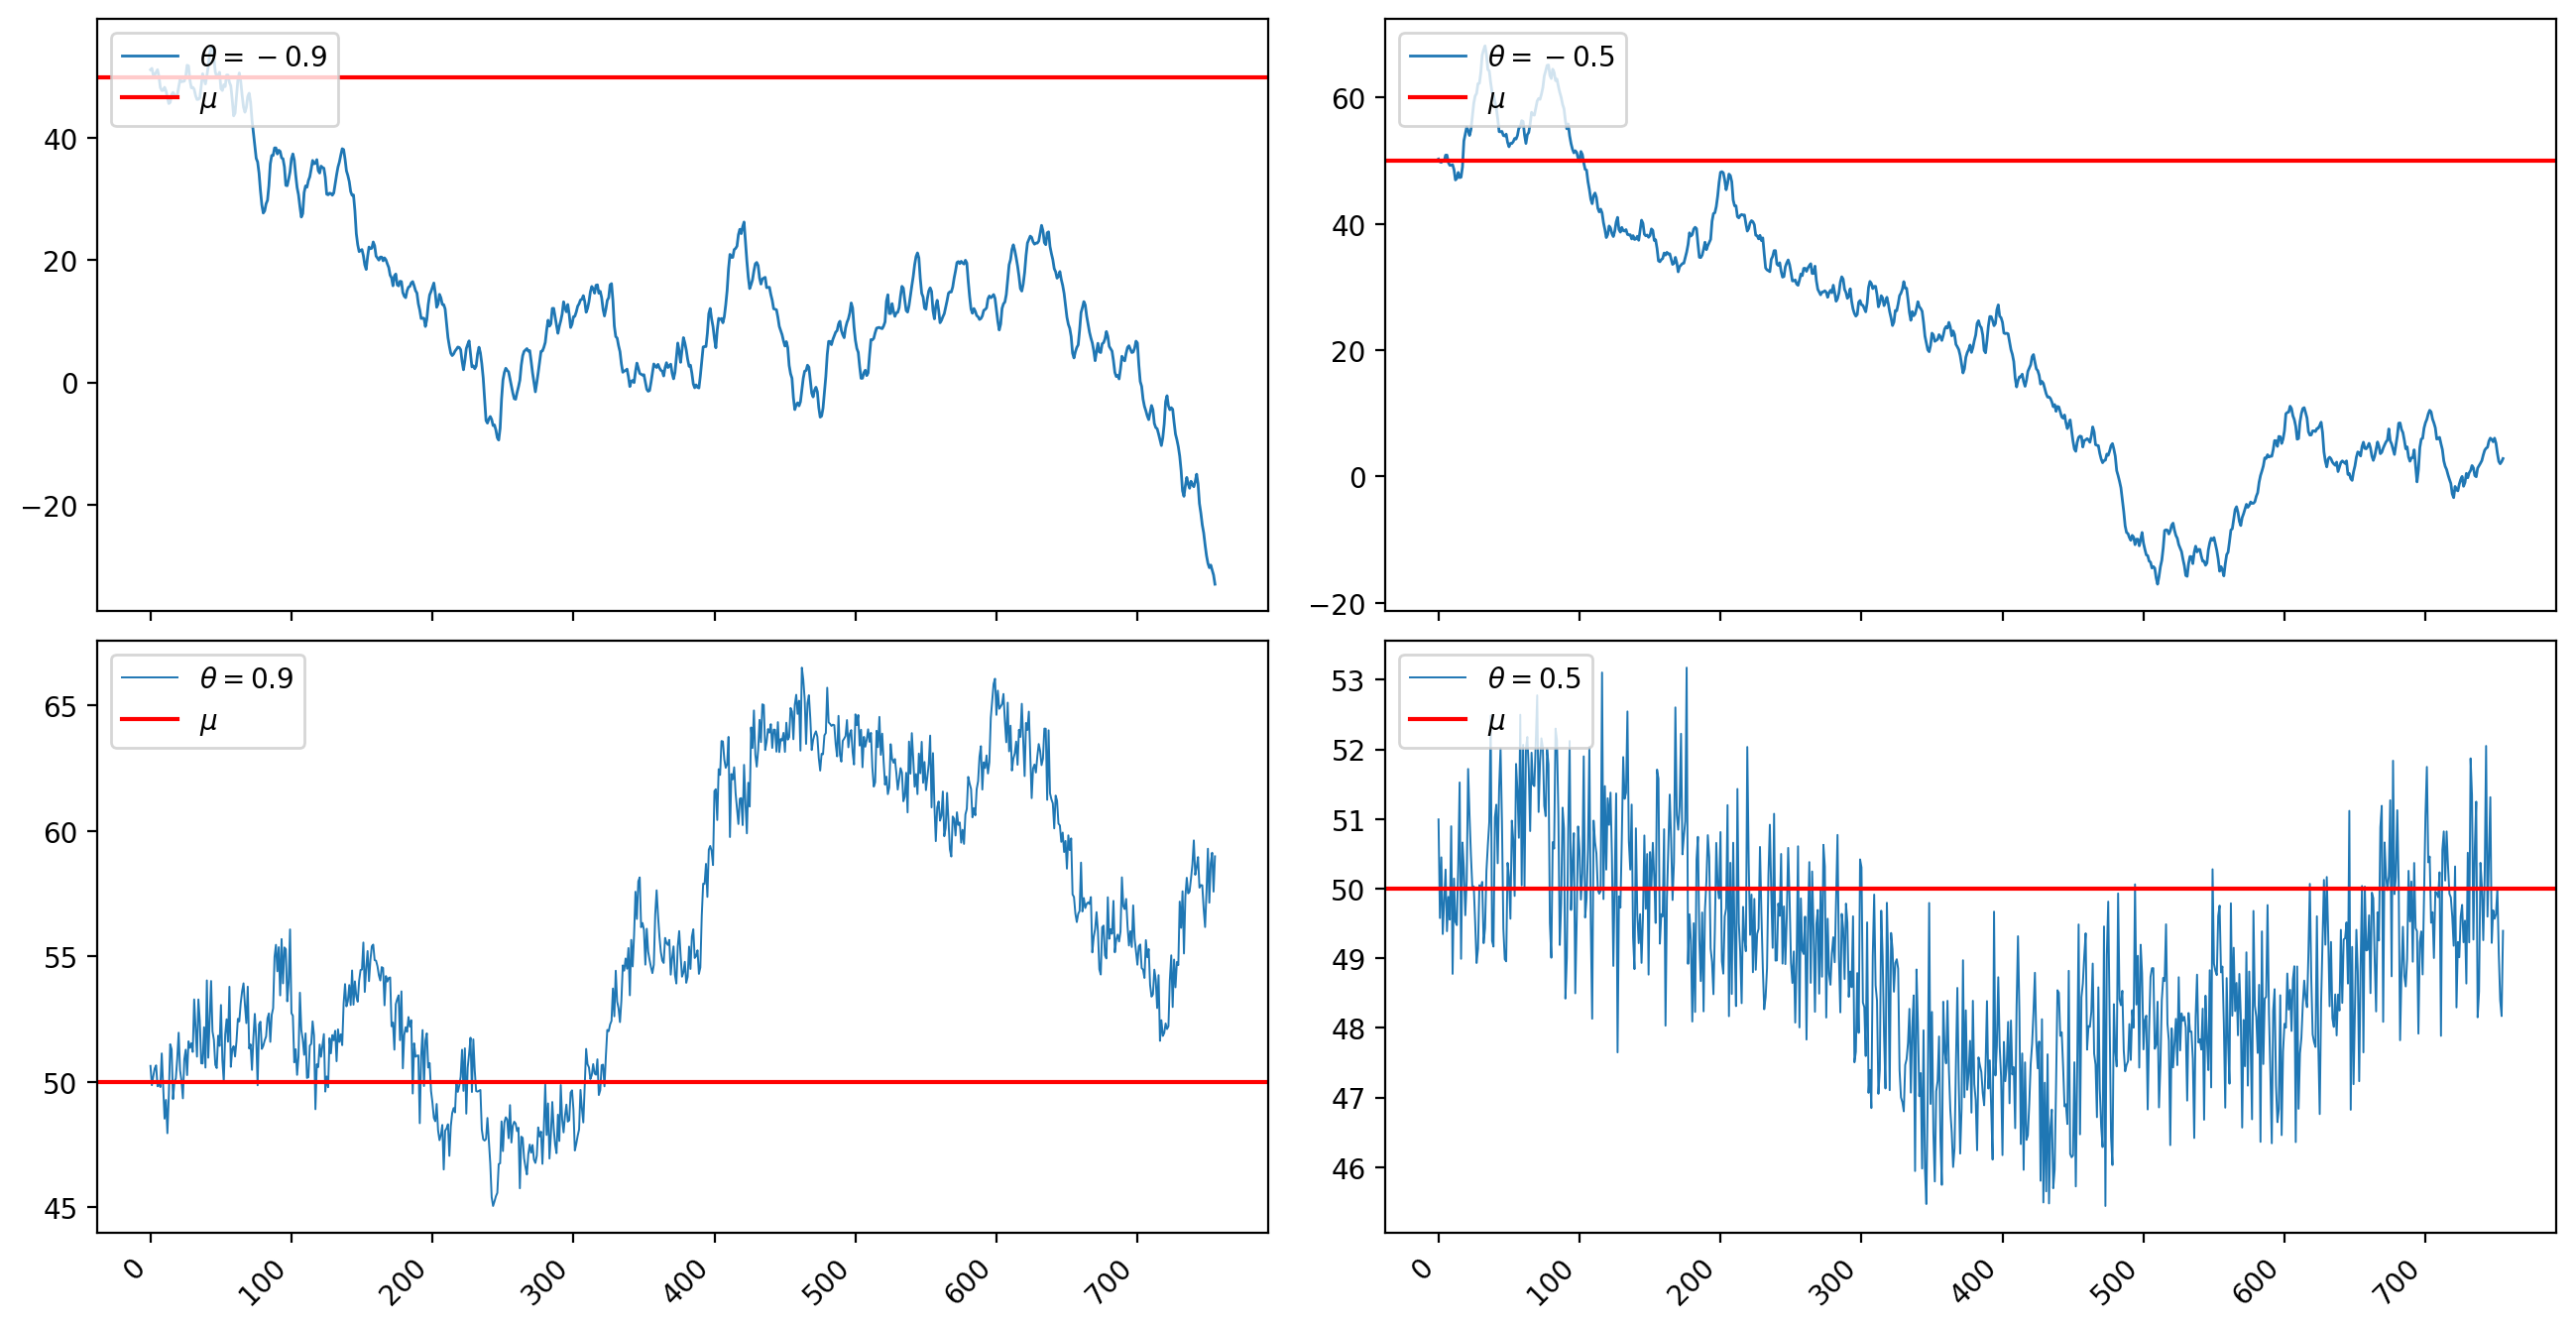

In [6]:
ma1 = [1, 0.9]
ma2 = [1, 0.5]
ma3 = [1, -0.5]
ma4 = [1, -0.9]

simulated_ma2_1 = s0 + np.cumsum(ArmaProcess(ma = ma1).generate_sample(nsample=N))
simulated_ma2_2 = s0 + np.cumsum(ArmaProcess(ma = ma2).generate_sample(nsample=N))
simulated_ma2_3 = s0 + np.cumsum(ArmaProcess(ma = ma3).generate_sample(nsample=N))
simulated_ma2_4 = s0 + np.cumsum(ArmaProcess(ma = ma4).generate_sample(nsample=N))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 9), sharex=True, dpi=200)
fig.subplots_adjust(hspace=.05, wspace=.1)
fig.autofmt_xdate(rotation=45)
axs[0][0].plot(simulated_ma2_1, linewidth=1, label=r'$\theta = -0.9$')
axs[0][0].axhline(y=s0, color='r', label='$\mu$')
axs[0][0].legend(loc = 'upper left')

axs[0][1].plot(simulated_ma2_2, linewidth=1, label=r'$\theta = -0.5$')
axs[0][1].axhline(y=s0, color='r', label='$\mu$')
axs[0][1].legend(loc = 'upper left')

axs[1][0].plot(simulated_ma2_3, linewidth=.7, label=r'$\theta= 0.9$')
axs[1][0].axhline(y=s0, color='r', label='$\mu$')
axs[1][0].legend(loc = 'upper left')

axs[1][1].plot(simulated_ma2_4, linewidth=.7, label=r'$\theta= 0.5$')
axs[1][1].axhline(y=s0, color='r', label='$\mu$')
axs[1][1].legend(loc = 'upper left')
plt.show()

## 1.4 GARCH $$y_t = \varepsilon_t \sigma_{t-1}$$



In [7]:
garch_simulations = []
for i in range(N_PATHES):
    garch_model = arch_model(np.random.standard_normal(size=N) * 10,
                            mean='Constant', dist='Normal').fit()
    simulated_garch = s0 + np.cumsum(garch_model.resid / garch_model.conditional_volatility)
    garch_simulations += [simulated_garch]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2881.794143864349
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2863.842455379218
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2802.881204462595
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2802.7853455096115
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2802.7137435801005
Iteration:      6,   Func. Count:     37,   Neg. LLF: 2802.7136237421846
Iteration:      7,   Func. Count:     42,   Neg. LLF: 2802.7131528796854
Iteration:      8,   Func. Count:     47,   Neg. LLF: 2802.712126950565
Iteration:      9,   Func. Count:     52,   Neg. LLF: 2802.7091747631775
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2802.7012720119665
Iteration:     11,   Func. Count:     62,   Neg. LLF: 2802.679945126053
Iteration:     12,   Func. Count:     67,   Neg. LLF: 2802.628067814472
Iteration:     13,   Func. Count:     72,   Neg. LLF: 2802.5697791908206
Iteration:     14,   Func. Count:     77,   Neg. LLF: 280

In [8]:
garch_df = pd.DataFrame(garch_simulations).T

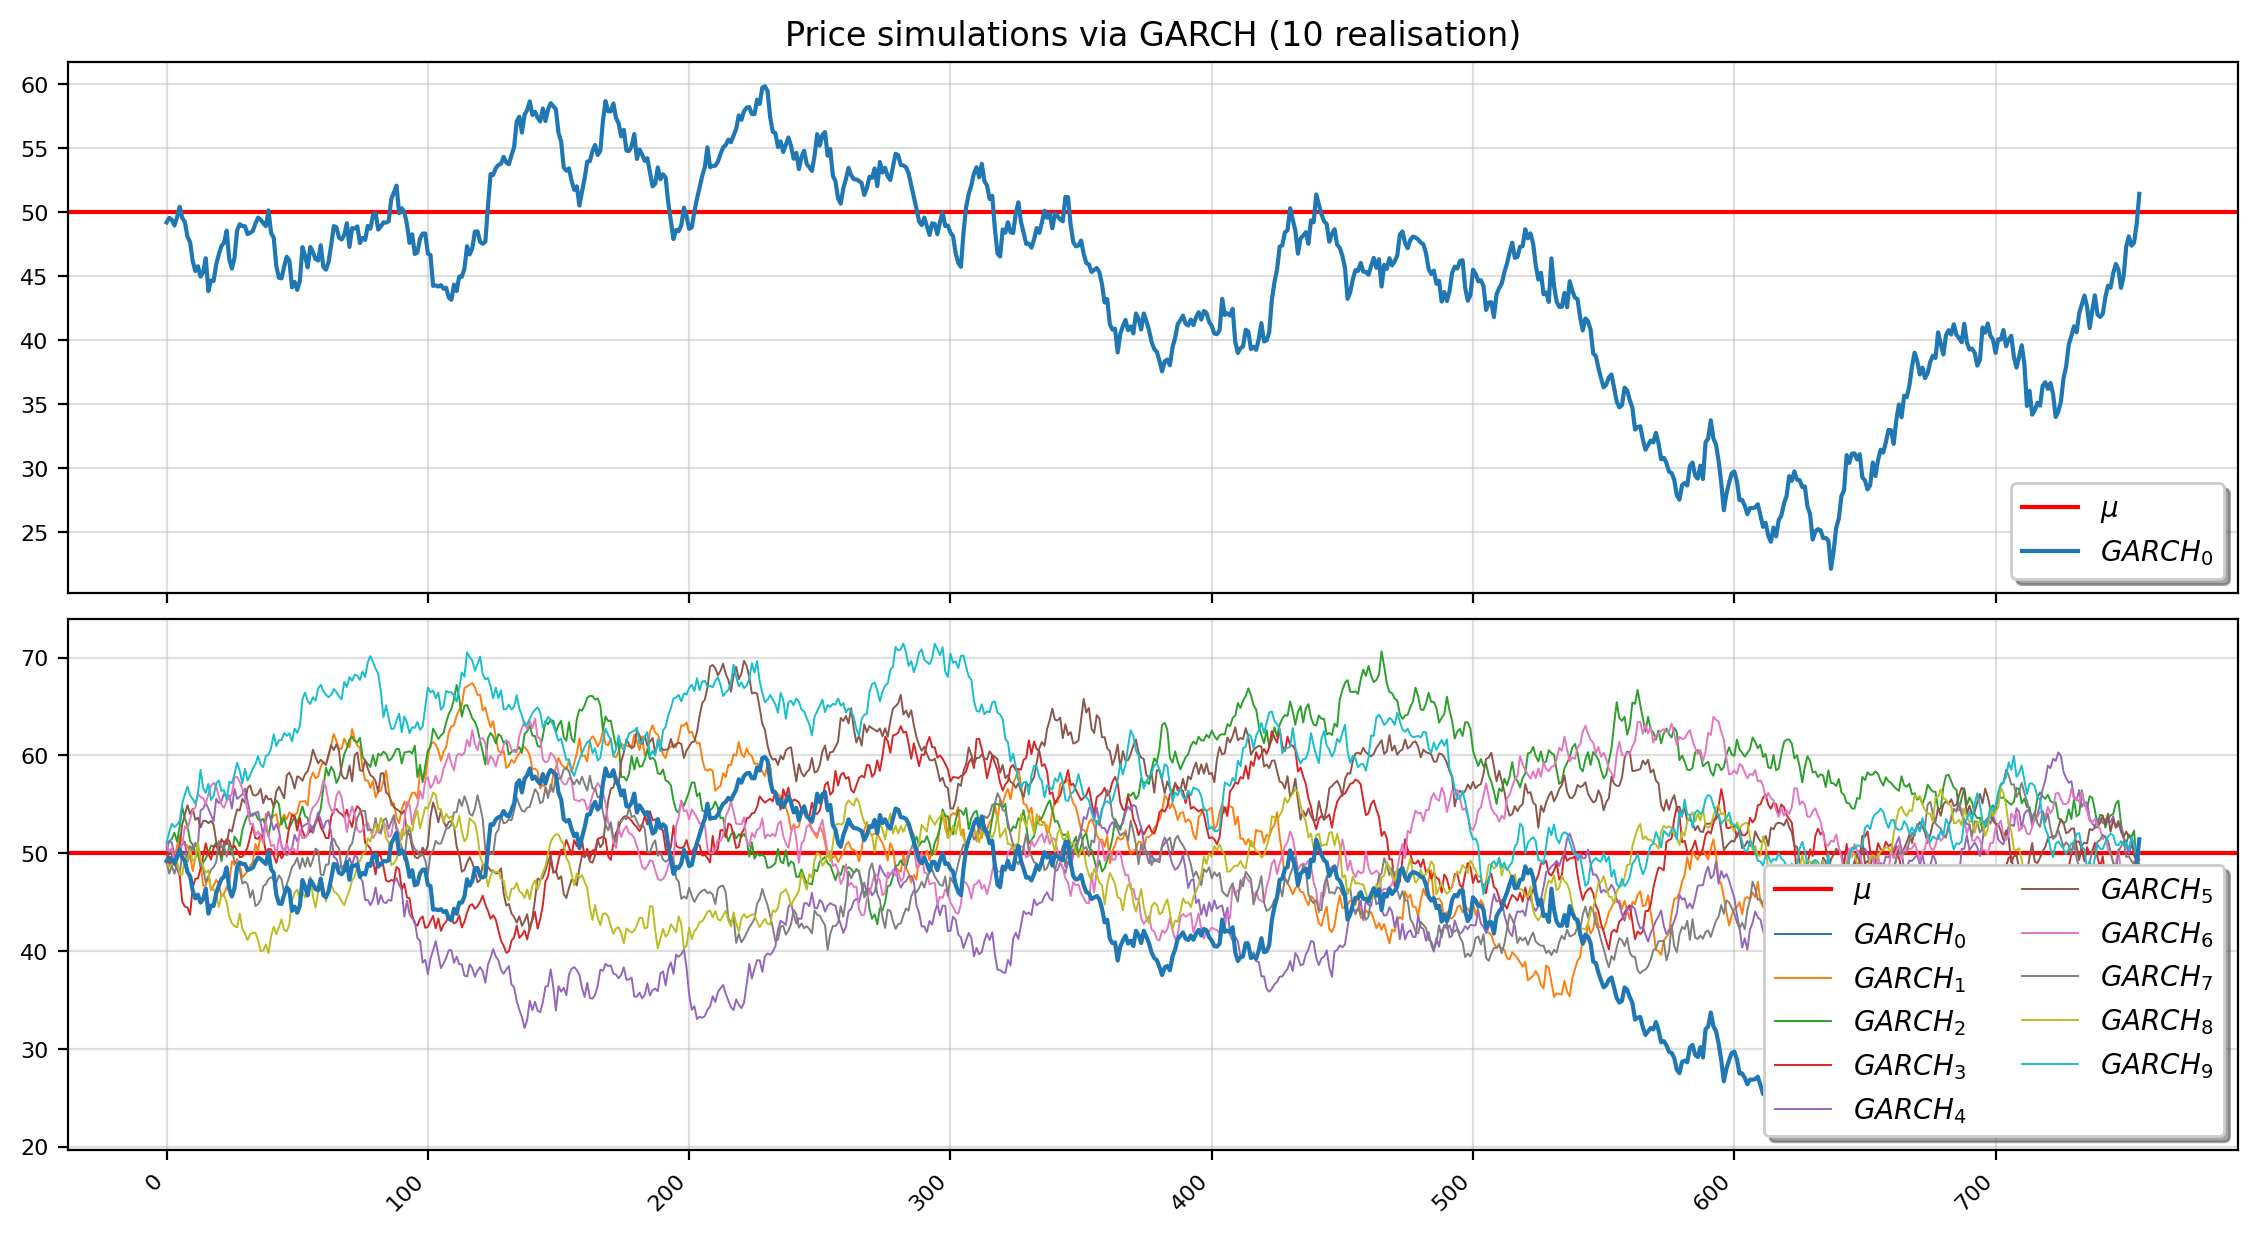

In [9]:
plot_stochastic_processes(garch_df, 'GARCH', title='GARCH')

# 1.6 Geometric Brownian Motion

In [10]:
def geometric_brownian_motion_log_returns(param):
    assert isinstance(param, ModelParameters)
    wiener_process = np.array(brownian_motion_log_returns(param))
    sigma_pow_mu_delta = ((param.gbm_mu - 0.5) * param.all_sigma ** 2) * param.all_delta
    return wiener_process + sigma_pow_mu_delta


def geometric_brownian_motion_levels(param):
    return convert_to_prices(param, geometric_brownian_motion_log_returns(param))

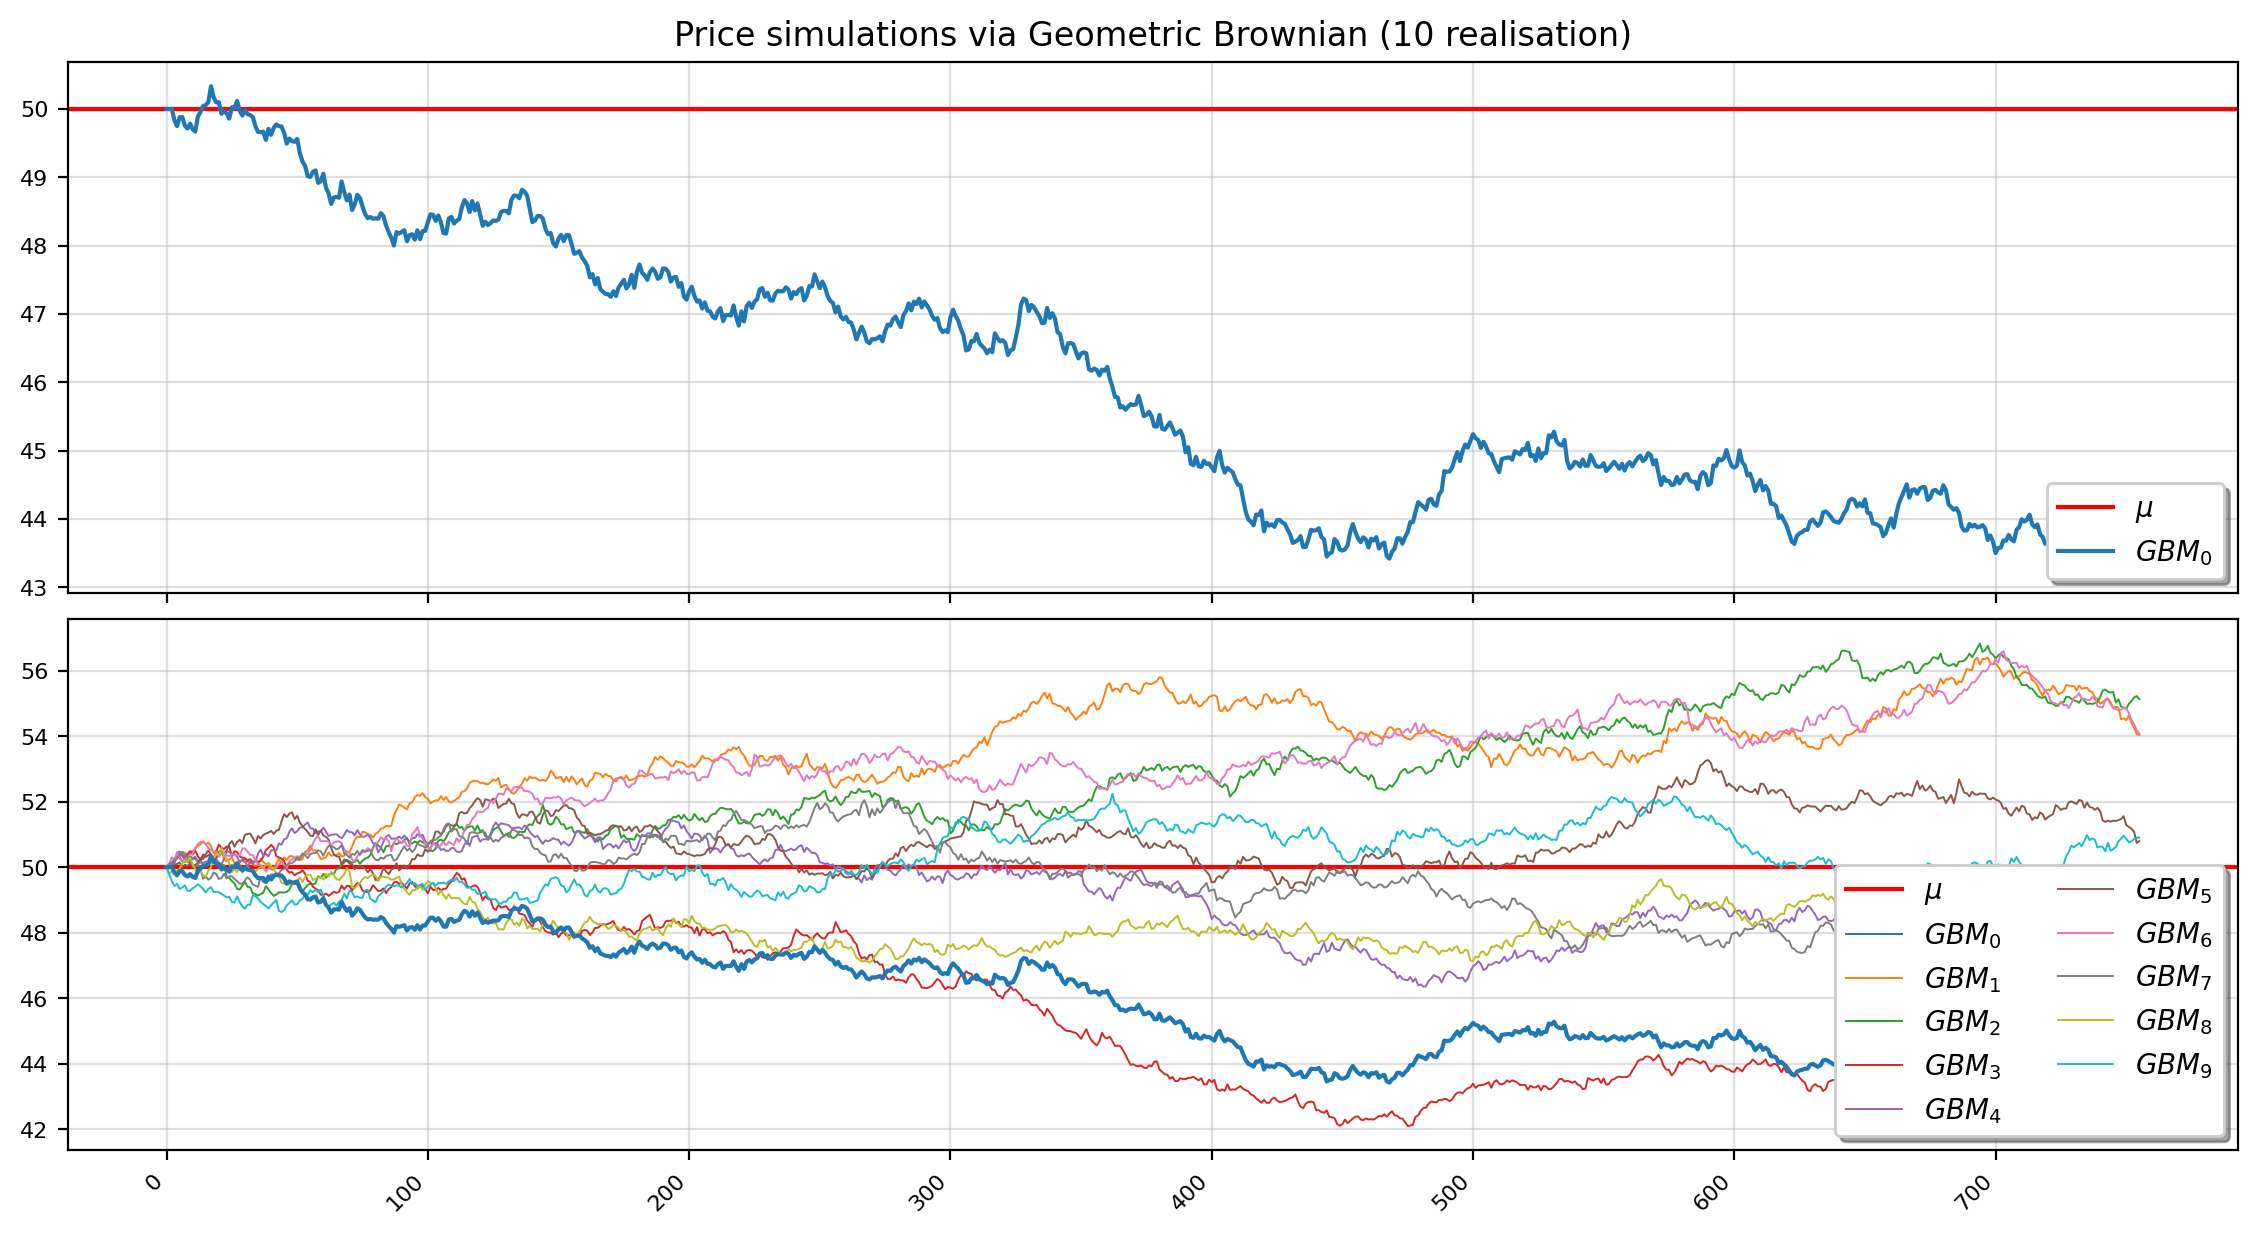

In [11]:
geom_brawn_df = pd.DataFrame([geometric_brownian_motion_levels(params) for i in range(N_PATHES)]).T

plot_stochastic_processes(geom_brawn_df, 'GBM', title='Geometric Brownian')

## 1.7 Merton Jump diffusion

In [12]:
def jump_diffusion_process(param):
    assert isinstance(param, ModelParameters)
    s_n = time = 0
    small_lamda = -(1.0 / param.lamda)
    jump_sizes = []
    for k in range(0, param.all_time):
        jump_sizes.append(0.0)
    while s_n < param.all_time:
        s_n += small_lamda * np.log(random.uniform(0, 1))
        for j in range(0, param.all_time):
            if time * param.all_delta <= s_n * param.all_delta <= (j + 1) * param.all_delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(param.jumps_mu, param.jumps_sigma)
                break
        time += 1
    return jump_sizes


def jump_diffusion_log_returns(param):
    assert isinstance(param, ModelParameters)
    jump_diffusion = jump_diffusion_process(param)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(param)
    return np.add(jump_diffusion, geometric_brownian_motion)


def jump_diffusion_levels(param):
    return convert_to_prices(param, jump_diffusion_log_returns(param))

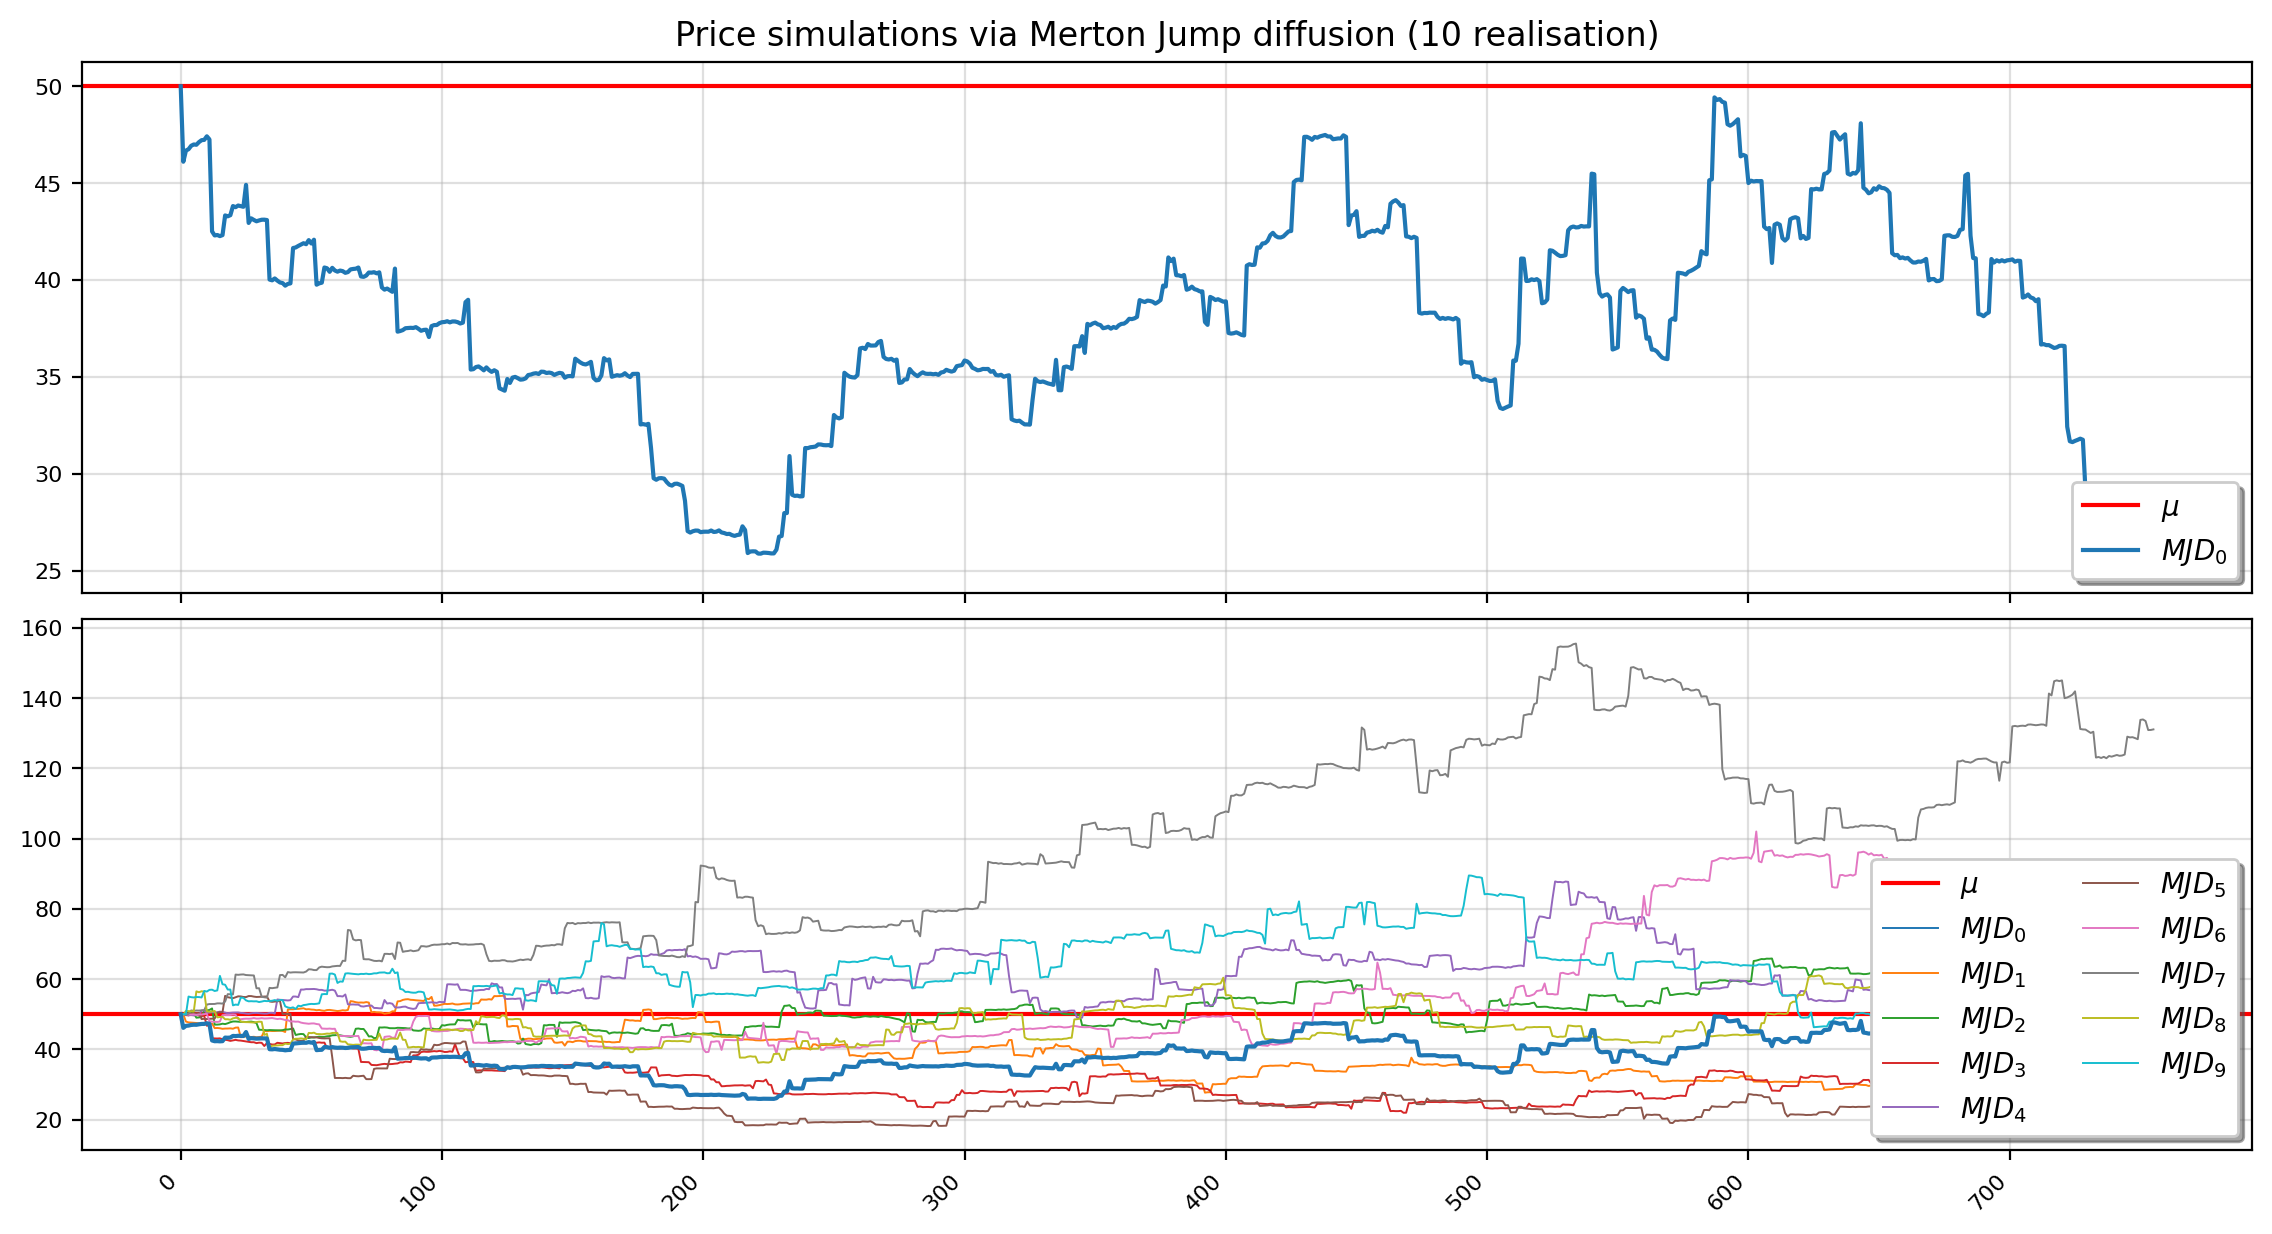

In [13]:
mjd_df = pd.DataFrame([jump_diffusion_levels(params) for i in range(N_PATHES)]).T

plot_stochastic_processes(mjd_df, 'MJD', title='Merton Jump diffusion')

# 1.8 Heston Stochastic volatility

In [14]:
def heston_paths(kappa, theta, v_0, rho, xi, Npaths):
    steps=params.all_time
    mu=params.all_s0
    dt = 1 / steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        mu = mu * (np.exp((-0.5 * v_t)*dt+ np.sqrt(v_t) * WT[:,0])) 
        v_t = np.abs(v_t + kappa*(theta - v_t) * dt + xi * np.sqrt(v_t) * WT[:,1])
        prices[:, t] = mu
    return pd.DataFrame(prices.T)


heston_df = heston_paths(kappa=4,
                                 theta=.02,
                                 v_0=0,
                                 rho=.6,
                                 xi=.7,
                                 Npaths=N_PATHES)

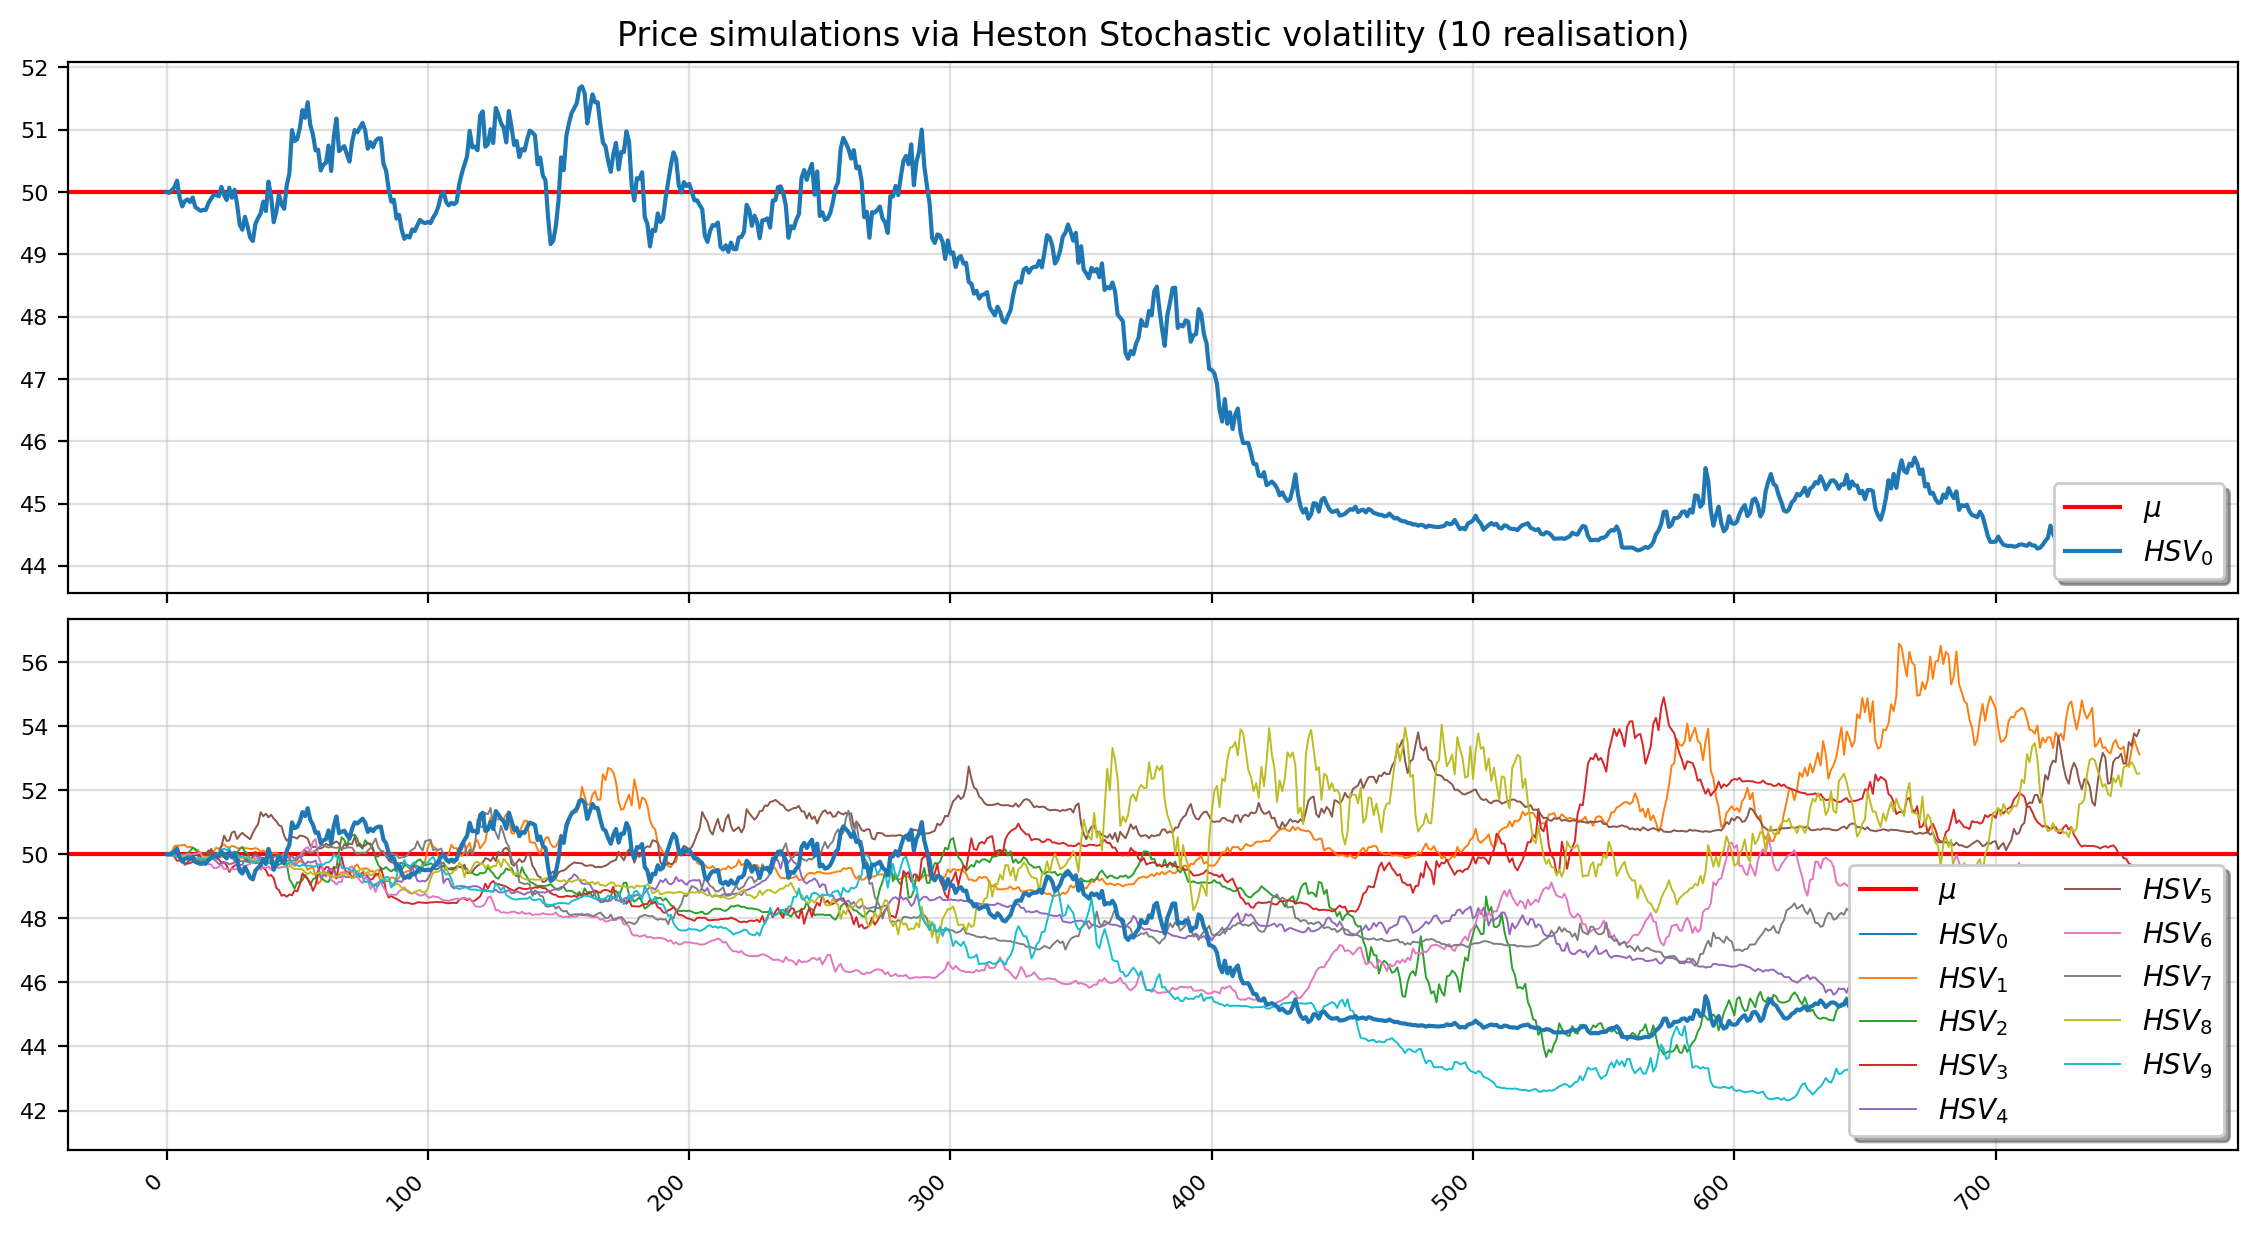

In [15]:
plot_stochastic_processes(heston_df, 'HSV', title='Heston Stochastic volatility')

# 2. Для сгенерированных процессов на всей выборке и на подвыборках посчитать характеристики (среднее, дисперсию и т.д.)

In [16]:
def print_moments(data):
    std = np.std(data, ddof=1)
    mean = np.mean(data)
    print('Выборочные характеристики:')
    print(f'Mean           : {mean:.4f}')
    print(f'Median         : {np.median(data):.4f}')
    print(f'Mode           : {stats.mode(data)[0][0]:.4f}')
    print(f'Variance       : {np.var(data, ddof=1):.4f}')
    print(f'Std.Deviation  : {std:.4f}')
    print(f'Коэфф.эксцесса    :  {stats.kurtosis(data):.2f}')
    print(f'Коэфф.асимметрии  : {stats.skew(data):.2f}\n')

def print_moments_subdata(data):
    data=data[0]
    print('Полная выборка:')
    print_moments(data)
    one_third = int(data.shape[0] / 3)
    parts = data[0: one_third], data[one_third: 2 * one_third], data[2 * one_third:]
    for num, part_df in enumerate(parts):
        print(f'Подвыборка #{num + 1}')
        print_moments(part_df)

### 2.1 Характеристики для Винеровского процесса

In [17]:
print_moments_subdata(W_df)

Полная выборка:
Выборочные характеристики:
Mean           : 49.9290
Median         : 49.9590
Mode           : 47.5610
Variance       : 1.1484
Std.Deviation  : 1.0716
Коэфф.эксцесса    :  -0.92
Коэфф.асимметрии  : -0.11

Подвыборка #1
Выборочные характеристики:
Mean           : 51.0260
Median         : 51.0838
Mode           : 49.5522
Variance       : 0.2860
Std.Deviation  : 0.5348
Коэфф.эксцесса    :  -0.03
Коэфф.асимметрии  : -0.48

Подвыборка #2
Выборочные характеристики:
Mean           : 49.3407
Median         : 49.2981
Mode           : 47.5610
Variance       : 0.8983
Std.Deviation  : 0.9478
Коэфф.эксцесса    :  -0.97
Коэфф.асимметрии  : -0.06

Подвыборка #3
Выборочные характеристики:
Mean           : 49.4202
Median         : 49.2981
Mode           : 47.7670
Variance       : 0.4544
Std.Deviation  : 0.6741
Коэфф.эксцесса    :  -0.94
Коэфф.асимметрии  : 0.19



### 2.2 Характеристики для Geometric Brownian Motion¶

In [18]:
print_moments_subdata(geom_brawn_df)

Полная выборка:
Выборочные характеристики:
Mean           : 46.0215
Median         : 45.5027
Mode           : 43.2714
Variance       : 3.8199
Std.Deviation  : 1.9544
Коэфф.эксцесса    :  -1.08
Коэфф.асимметрии  : 0.40

Подвыборка #1
Выборочные характеристики:
Mean           : 48.3243
Median         : 48.2978
Mode           : 46.8292
Variance       : 0.9063
Std.Deviation  : 0.9520
Коэфф.эксцесса    :  -0.95
Коэфф.асимметрии  : 0.41

Подвыборка #2
Выборочные характеристики:
Mean           : 45.4457
Median         : 45.5027
Mode           : 43.4193
Variance       : 1.6700
Std.Deviation  : 1.2923
Коэфф.эксцесса    :  -1.54
Коэфф.асимметрии  : -0.13

Подвыборка #3
Выборочные характеристики:
Mean           : 44.2945
Median         : 44.3112
Mode           : 43.2714
Variance       : 0.2621
Std.Deviation  : 0.5120
Коэфф.эксцесса    :  -1.28
Коэфф.асимметрии  : -0.07



###  2.3 Характеристики для моделирования GARCH

In [19]:
print_moments_subdata(garch_df)

Полная выборка:
Выборочные характеристики:
Mean           : 44.5992
Median         : 46.0427
Mode           : 22.1376
Variance       : 68.2353
Std.Deviation  : 8.2605
Коэфф.эксцесса    :  -0.22
Коэфф.асимметрии  : -0.61

Подвыборка #1
Выборочные характеристики:
Mean           : 51.1531
Median         : 50.0865
Mode           : 43.1556
Variance       : 19.2966
Std.Deviation  : 4.3928
Коэфф.эксцесса    :  -1.18
Коэфф.асимметрии  : 0.13

Подвыборка #2
Выборочные характеристики:
Mean           : 46.6041
Median         : 47.2029
Mode           : 37.5589
Variance       : 18.8588
Std.Deviation  : 4.3427
Коэфф.эксцесса    :  -0.91
Коэфф.асимметрии  : -0.10

Подвыборка #3
Выборочные характеристики:
Mean           : 36.0403
Median         : 36.4262
Mode           : 22.1376
Variance       : 46.3880
Std.Deviation  : 6.8109
Коэфф.эксцесса    :  -1.09
Коэфф.асимметрии  : -0.00



### 2.4 Характеристики для Merton Jump diffusion

In [20]:
print_moments_subdata(mjd_df)

Полная выборка:
Выборочные характеристики:
Mean           : 37.9232
Median         : 38.0260
Mode           : 25.0899
Variance       : 30.0545
Std.Deviation  : 5.4822
Коэфф.эксцесса    :  -0.11
Коэфф.асимметрии  : -0.41

Подвыборка #1
Выборочные характеристики:
Mean           : 35.7793
Median         : 35.3862
Mode           : 25.8718
Variance       : 33.2024
Std.Deviation  : 5.7622
Коэфф.эксцесса    :  -0.75
Коэфф.асимметрии  : -0.05

Подвыборка #2
Выборочные характеристики:
Mean           : 38.4640
Median         : 37.6970
Mode           : 32.5327
Variance       : 14.5430
Std.Deviation  : 3.8135
Коэфф.эксцесса    :  -0.13
Коэфф.асимметрии  : 0.82

Подвыборка #3
Выборочные характеристики:
Mean           : 39.5264
Median         : 40.9483
Mode           : 25.0899
Variance       : 35.1691
Std.Deviation  : 5.9304
Коэфф.эксцесса    :  0.59
Коэфф.асимметрии  : -1.01



### 2.4 Характеристики для Heston Stochastic volatility

In [21]:
print_moments_subdata(heston_df)

Полная выборка:
Выборочные характеристики:
Mean           : 47.4201
Median         : 47.9306
Mode           : 43.9542
Variance       : 6.4826
Std.Deviation  : 2.5461
Коэфф.эксцесса    :  -1.71
Коэфф.асимметрии  : 0.05

Подвыборка #1
Выборочные характеристики:
Mean           : 50.1676
Median         : 50.0432
Mode           : 49.0412
Variance       : 0.4207
Std.Deviation  : 0.6486
Коэфф.эксцесса    :  -0.92
Коэфф.асимметрии  : 0.32

Подвыборка #2
Выборочные характеристики:
Mean           : 47.3477
Median         : 47.9306
Mode           : 44.5889
Variance       : 4.1428
Std.Deviation  : 2.0354
Коэфф.эксцесса    :  -1.45
Коэфф.асимметрии  : -0.08

Подвыборка #3
Выборочные характеристики:
Mean           : 44.7451
Median         : 44.6574
Mode           : 43.9542
Variance       : 0.1679
Std.Deviation  : 0.4098
Коэфф.эксцесса    :  -0.86
Коэфф.асимметрии  : 0.37



---

# 3. Для 3-ех процессов посмотреть распределения для нескольких (>=2) срезов времени.
Рассмотрим:
1. Винеровский процесс
2. Geometric Brownian Motion
3. Heston Stochastic volatility

In [22]:
def slicing(data):
    data = data[0]
    one_third = int(data.shape[0] / 3)
    parts = (data, data[0: one_third], data[one_third: 2 * one_third], data[2 * one_third:])
    return parts

def plot_slices_distributions(data):
    parts = slicing(data)
    fig, axs = plt.subplots(ncols=4,nrows=2, figsize=(16, 9))
    sns.histplot(parts[0], color='c', ax=axs[0][0], alpha=.4)
    sns.histplot(parts[1], color='b', ax=axs[0][1], alpha=.4)
    sns.histplot(parts[2], color='r', ax=axs[0][2], alpha=.4)
    sns.histplot(parts[3], color='g', ax=axs[0][3], alpha=.4)

    sns.kdeplot(parts[0], color='c', ax=axs[1][0], alpha=.6, fill=True)
    sns.kdeplot(parts[1], color='b', ax=axs[1][1], alpha=.6, fill=True)
    sns.kdeplot(parts[2], color='r', ax=axs[1][2], alpha=.6, fill=True)
    sns.kdeplot(parts[3], color='g', ax=axs[1][3], alpha=.6, fill=True)

    axs[0][0].legend(['Full Data'], loc="upper right")
    axs[0][1].legend(['1st slice'],loc="upper right")
    axs[0][2].legend(['2st slice'], loc="upper right")
    axs[0][3].legend(['3rd slice'], loc="upper right")

    axs[1][0].legend(['Full Data'], loc="upper right")
    axs[1][1].legend(['1st slice'],loc="upper right")
    axs[1][2].legend(['2st slice'], loc="upper right")
    axs[1][3].legend(['3rd slice'], loc="upper right")
    plt.show()

### 3.1.1 Распределения для Винеровского процесса

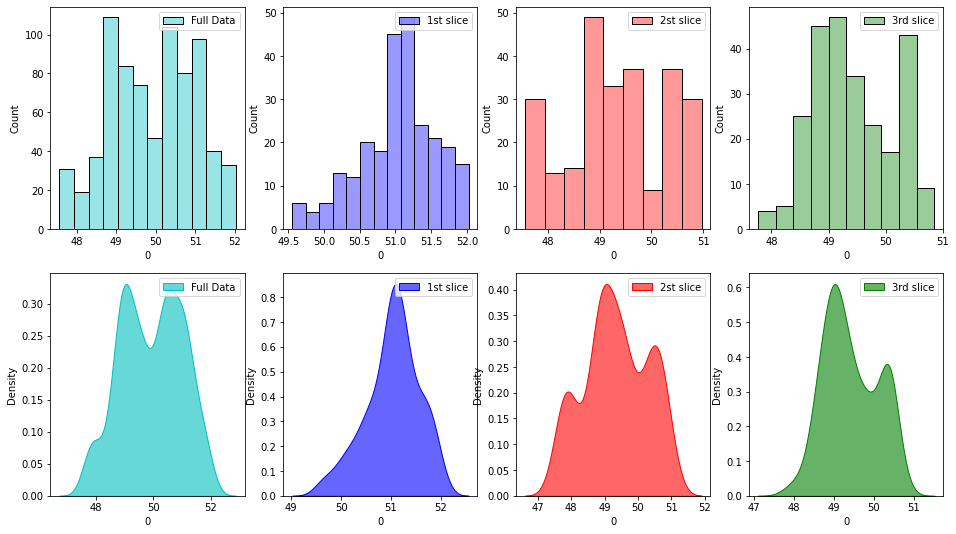

In [23]:
plot_slices_distributions(W_df)

### 3.1.2 Распределения для стационарных приращений Винеровского процесса

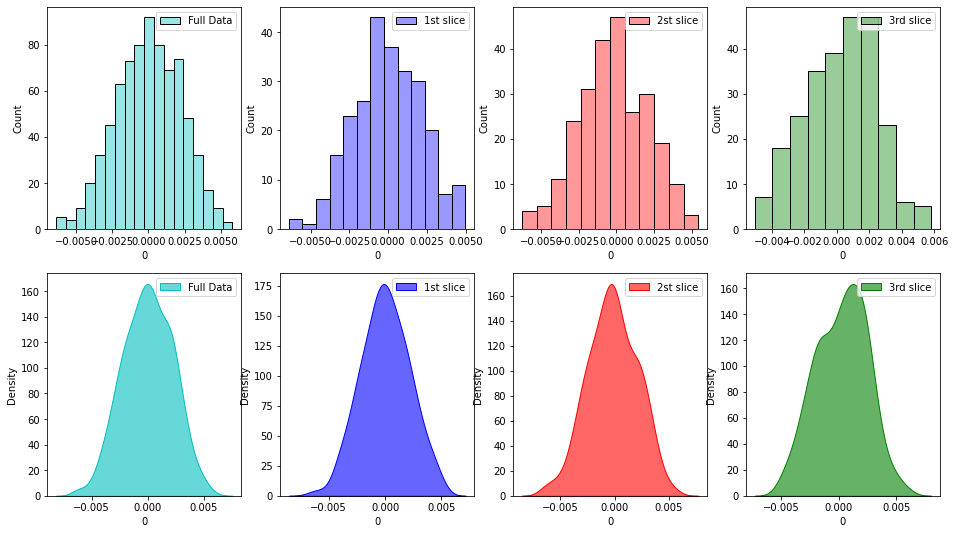

In [24]:
plot_slices_distributions(W_df.pct_change())

### 3.2.1 Распределения для процесса Geometric Brownian Motion

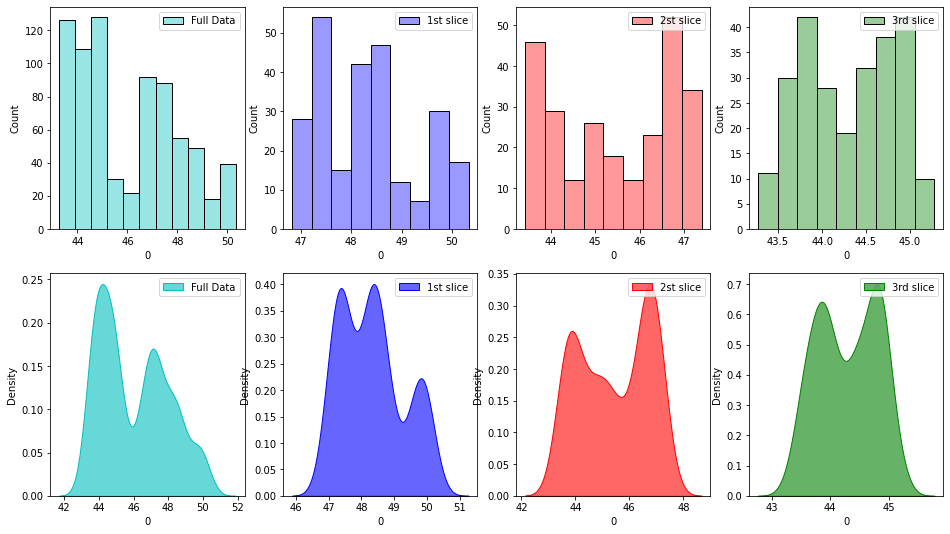

In [25]:
plot_slices_distributions(geom_brawn_df)

### 3.2.2 Распределения для стационарных приращений Geometric Brownian Motion

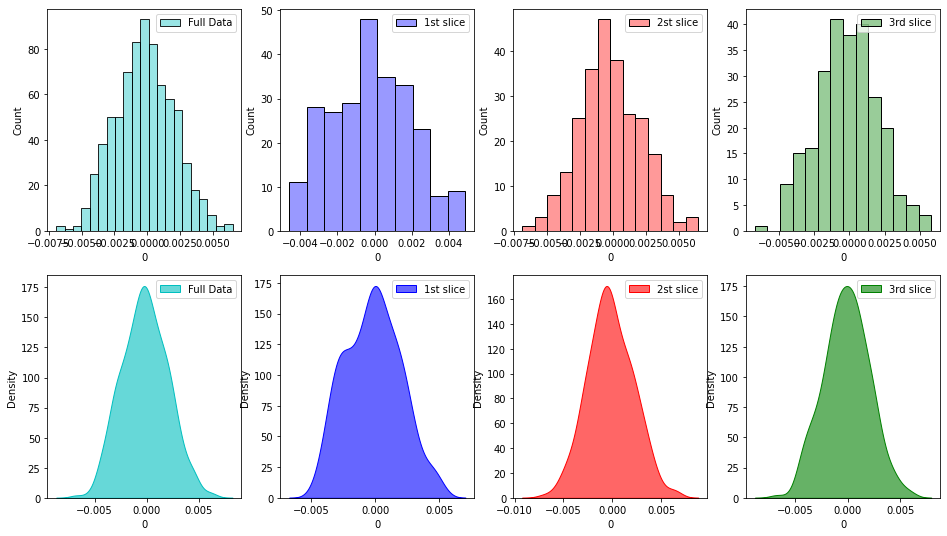

In [26]:
plot_slices_distributions(geom_brawn_df.pct_change())

### 3.3.1 Распределения для процесса Heston Stochastic volatility

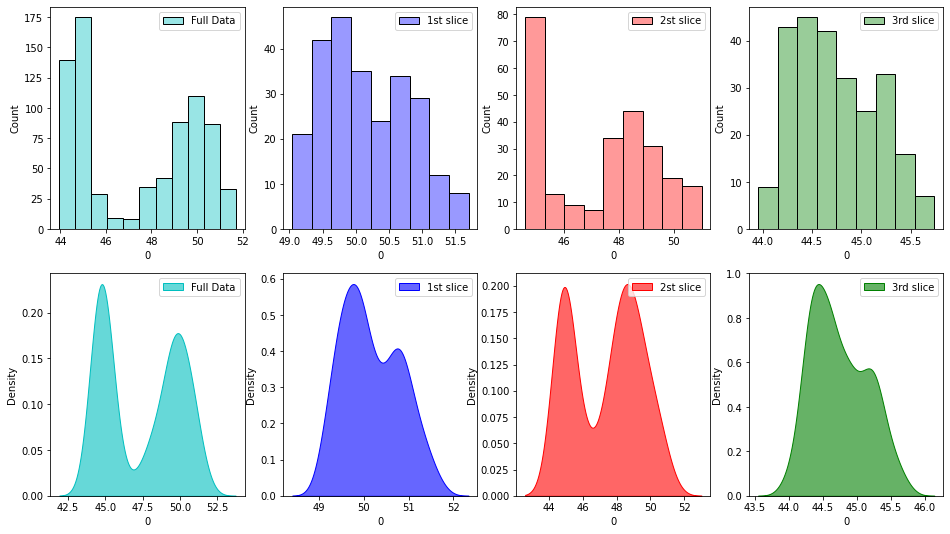

In [27]:
plot_slices_distributions(heston_df)

### 3.3.2 Распределения для стационарных приращений Heston Stochastic volatility

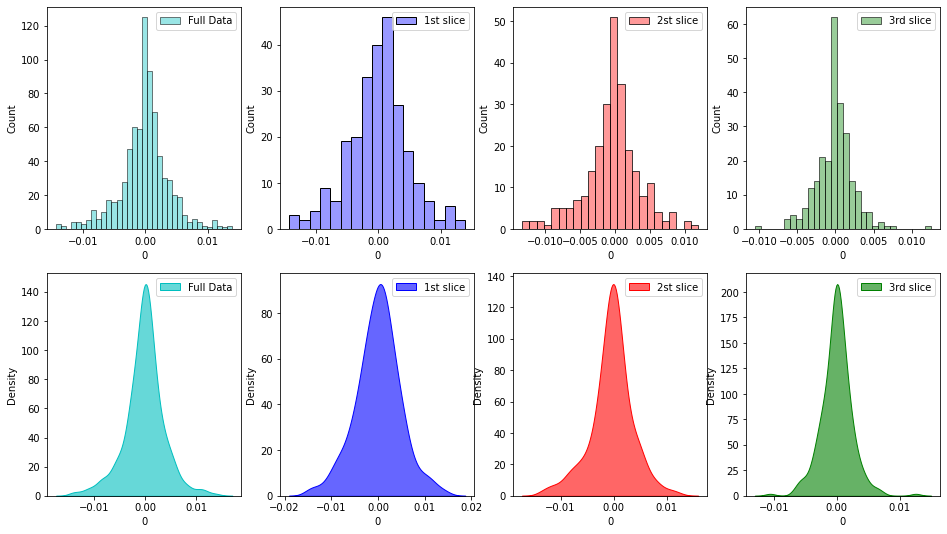

In [28]:
plot_slices_distributions(heston_df.pct_change())

# 4. Провести тесты на стационарность для некоторых траекторий выбранных процессов. Перейти к доходностям и посчитать VaR

### 4.1 Проверка на стационарность

Проверим на стационарность по одной траектории из процессов:
1. Винеровский
2. Geometric Brownian Motion
3. Heston Stochastic volatility

In [29]:
from statsmodels.tsa.stattools import adfuller

Для проверки воспользуемся тестом Дики-Фуллера

* `p-value > 0.05`: Fail to reject the null hypothesis (`H0`), the data has a unit root and is non-stationary.
* `p-value <= 0.05`: Reject the null hypothesis (`H0`), the data does not have a unit root and is stationary.

#### Перейдем к доходностям

In [30]:
ret_W = W_df[0].pct_change().dropna()
ret_geom_brawn = geom_brawn_df[0].pct_change().dropna()
ret_heston = heston_df[0].pct_change().dropna()

In [31]:
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {p_value:.4f}')
    if p_value <= 0.05:
        print('Process is Stationary\n')
    else:
        print('Process is NonStationary\n')

In [32]:
check_stationarity(ret_W)

check_stationarity(ret_geom_brawn)

check_stationarity(ret_heston)

ADF Statistic: -20.23
p-value: 0.0000
Process is Stationary

ADF Statistic: -29.05
p-value: 0.0000
Process is Stationary

ADF Statistic: -6.93
p-value: 0.0000
Process is Stationary



### Вывод:
Доходности выбранных траекторий всех трех процессов стационарны, согласно тесту Дики-Фуллера.

### 4.1 Рассчет VaR

In [33]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    for i in tqdm(range(L_history, len(r))):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)  
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

def calculate_VaR_FHS_EVT(ret, alpha=0.05):
    scaling_const = 10.0 / ret.std()

    mdl = arch_model(scaling_const * ret,
                        mean='HARX', lags=1,
                        vol='Garch', p=1, o=1, q=1,
                        dist='normal')
    res = mdl.fit(disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const
    u = conditional_sr.quantile(0.25)
    ret_tail = conditional_sr[conditional_sr <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    VaR_FHS_EVT_forecast = -abs(u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1))

    return VaR_FHS_EVT_forecast

In [34]:
VaR_FHS_EVT_W = calc_VaR(ret_W, calculate_VaR_FHS_EVT, L_history=252, level=0.05)
VaR_FHS_EVT_GBM = calc_VaR(ret_geom_brawn, calculate_VaR_FHS_EVT, L_history=252, level=0.05)
VaR_FHS_EVT_H = calc_VaR(ret_heston, calculate_VaR_FHS_EVT, L_history=252, level=0.05)

100%|█████████████████████████████████████████| 503/503 [00:45<00:00, 11.10it/s]


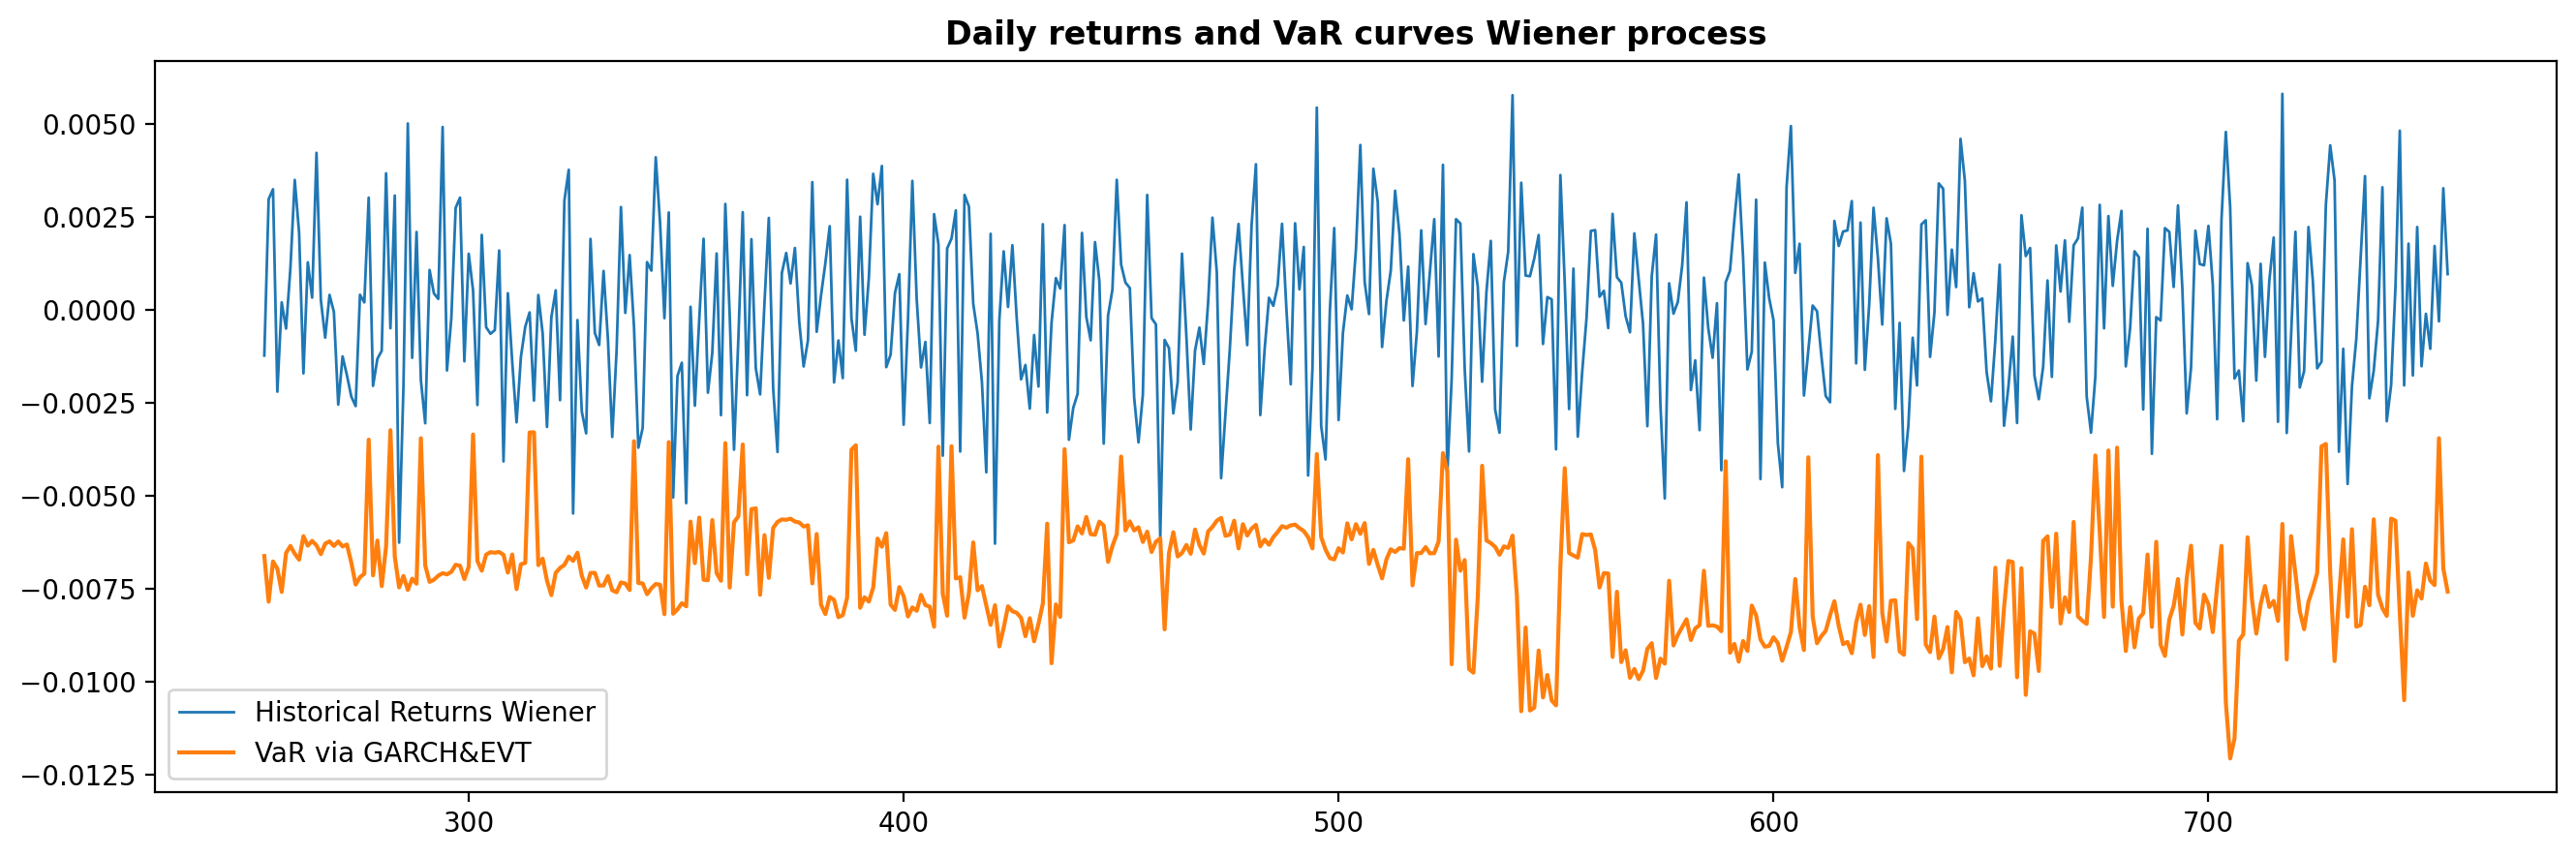

In [35]:
fig = plt.figure(figsize=(16, 5), dpi=200)
plt.plot(ret_W[252:], label = 'Historical Returns Wiener', linewidth=1, )
plt.plot(VaR_FHS_EVT_W, label = 'VaR via GARCH&EVT')
plt.title("Daily returns and VaR curves Wiener process", weight="bold")
plt.legend()
plt.show()

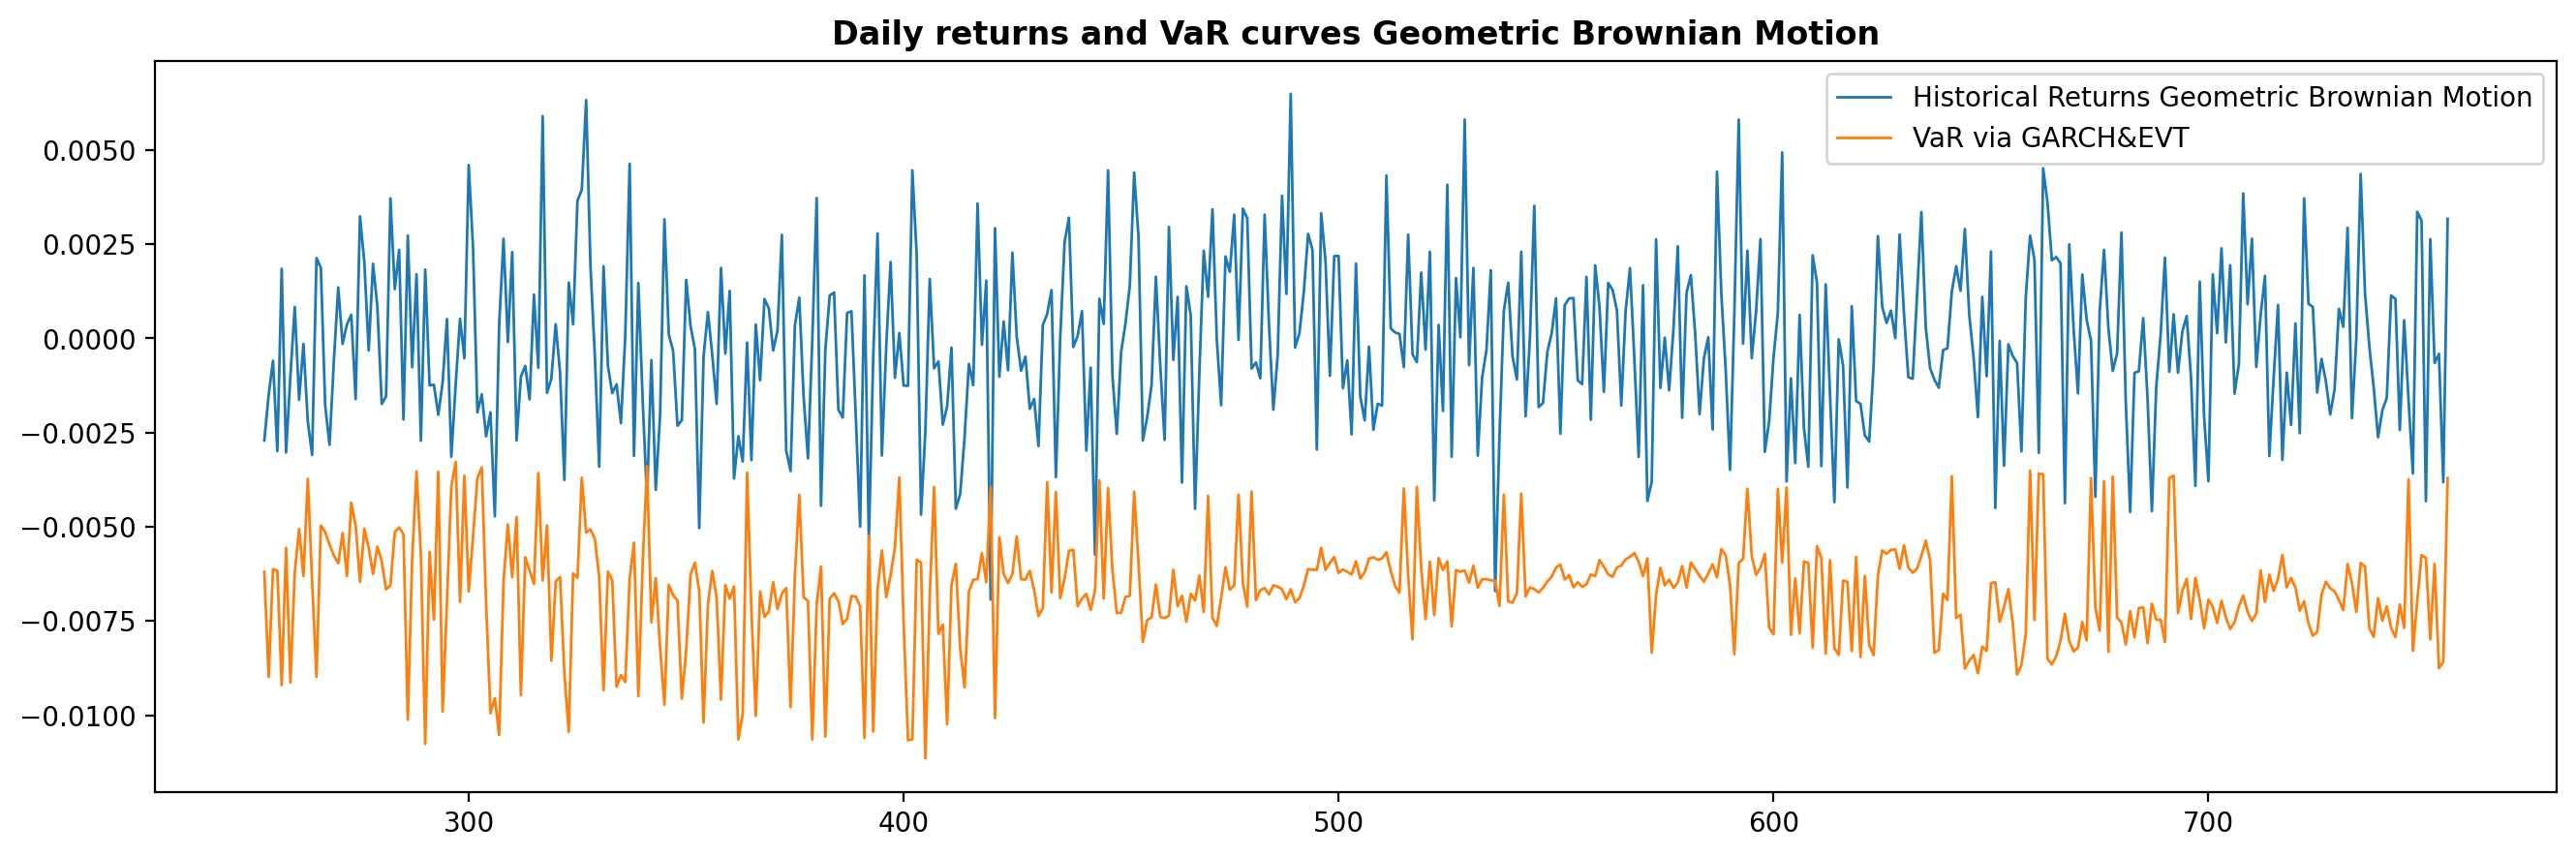

In [36]:
fig = plt.figure(figsize=(16, 5), dpi=200)
plt.plot(ret_geom_brawn[252:], label = 'Historical Returns Geometric Brownian Motion', linewidth=1, )
plt.plot(VaR_FHS_EVT_GBM, label = 'VaR via GARCH&EVT', linewidth=1)
plt.title("Daily returns and VaR curves Geometric Brownian Motion", weight="bold")
plt.legend()
plt.show()

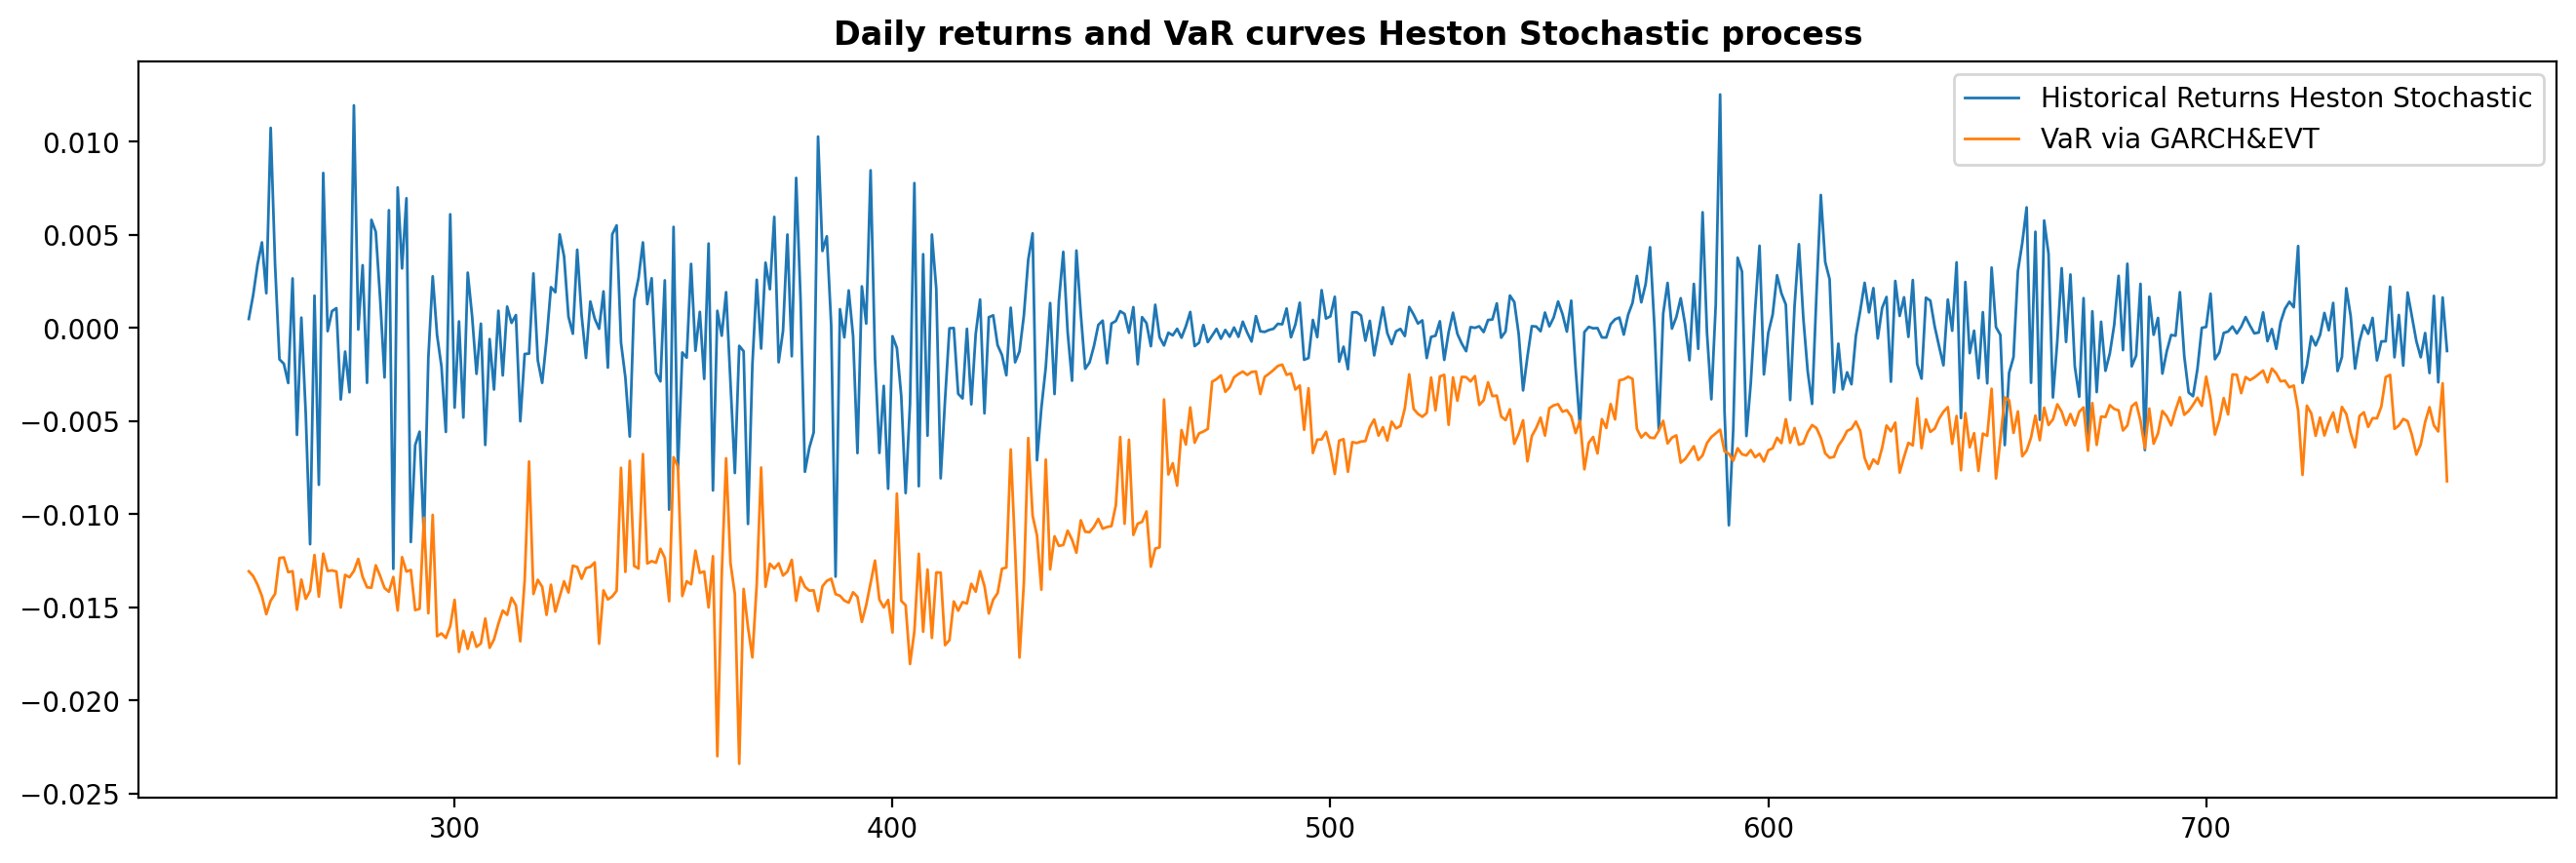

In [37]:
fig = plt.figure(figsize=(16, 5), dpi=200)
plt.plot(ret_heston[252:], label = 'Historical Returns Heston Stochastic', linewidth=1)
plt.plot(VaR_FHS_EVT_H, label = 'VaR via GARCH&EVT', linewidth=1)
plt.title("Daily returns and VaR curves Heston Stochastic process", weight="bold")
plt.legend()
plt.show()

---